# Analysis of Beta Series Correlations

This notebook walks through the exploration of beta series correlations extracted from both task and rest data.
The rest data was treated like the task data, that is, any event that happened during the task we pretend the event also happened during rest.

The expectation is that beta series correlations from a task will "look different" from the beta series correlations from rest.
Demonstrating the difference will provide a validity check for [NiBetaSeries](https://nibetaseries.readthedocs.io/en/stable/).

I will attempt to measure the difference between task and rest with multiple approaches.

1. The average within/between network correlations will be different between task and rest
  - specifically I expect both the between and within network correlations to be higher during task, since there is a low likelihood of there being a BOLD response during the resting state data.
2. The correlation contrast between task and rest will different from zero.
  - To maximize the potential to detect a difference, subtracting the rest correlation matrix from the task correlation matrix from every participant _should_ result in the greatest possible difference.
  - I will use an activation atlas and the schaefer atlas to make sure results/conclusions are robust
3. The correlation contrasts between task/rest, dual/single, repeat/single, and dual/repeat will have more positives using LSS relative to LSA.

**UPDATE:**

The first hypothesis has no visual support, in fact, as you will see the average within network correlation is greater for the resting state data.
The average between network correlation also does not appear to be different between the two.

Since the rest data beta series had more structure than anticipated, a couple graph theoretical measures were added.

4. The participation coefficient for the task data should be closer to 1 relative to the rest data.
   This supports the finding by Wig (2017)
5. Conversly, the clustering coefficient should be lower for the task data relative to the rest data.
6. Modularity should also be lower for the task data

## Settings/Constants
You will probably need to change these settings to have the notebook work for you.

In [1]:
import os
# have to set the R path before I can use notebook_functions
R_PATH = "/home/jdkent/envs/aim1_valid/lib/R"
os.environ['R_HOME'] = R_PATH

# other constants

# number of threads you wish to parallelize across
N_THREADS = 32

# paths to the results
LSS_SCH_PATH = '../lss-schaeferparcel-400/nibetaseries'
LSA_SCH_PATH = '../lsa-schaeferparcel-400/nibetaseries'

LSS_ACT_PATH = '../lss-overallresponse/nibetaseries'
LSA_ACT_PATH = '../lsa-overallresponse/nibetaseries'

# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# path to participants file
PARTICIPANT_DEMO = '../../participants.tsv'

# absolute max the z-value can be for fisher's r->z transform
THRESH = 2.647

# activation atlas
ACT_ATLAS = '../data/overall_response_atlas.nii.gz'


OVERWRITE_IMAGES = False

PLOT_SCHAEFER = False

## Libraries
These are the packages used in this notebook, including `notebook_functions` which isolates some repeated code sections to keep the notebook clearer.

In [295]:
import re
from subprocess import call

import seaborn as sns
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_chisquare, binom_test, proportion_confint
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from multiprocessing.pool import Pool
from bids.layout import BIDSLayout
from sklearn.metrics import confusion_matrix
from statsmodels.stats.multitest import multipletests
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker

# binomial significance test
# https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html
import notebook_functions as nf

def save_eps(fig, fname):
    fig.savefig(fname + '.pdf', bbox_inches='tight')
    call(["pdf2ps", fname + '.pdf', fname + '.eps'])
    os.remove(fname + '.pdf')

In [3]:
import importlib
importlib.reload(nf)

<module 'notebook_functions' from '/home/jdkent/hpchome/bids/derivatives/nibsAnalysis/notebook_functions.py'>

## Find/Aggregate the files

pybids is an awesome tool to index and query the data on your computer.
The layout variables contain all the information needed to extract where my correlation files are and what attributes they have (e.g., are they from task or rest, are they from the repeat or dual trial type, etc.)

### load the bold qa measures

In [4]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

bids_name       aor       aqi  dummy_trs  \
0    sub-GE120001_ses-pre_task-fauxbold_bold  0.001063  0.006351          2   
3  sub-GE120001_ses-pre_task-taskswitch_bold  0.003942  0.005572          2   
4    sub-GE120002_ses-pre_task-fauxbold_bold  0.002056  0.010868          1   
7  sub-GE120002_ses-pre_task-taskswitch_bold  0.002134  0.004827          1   
8    sub-GE120003_ses-pre_task-fauxbold_bold  0.003094  0.018135          1   

   dvars_nstd  dvars_std  dvars_vstd       efc        fber   fd_mean  ...  \
0   16.187316   1.198663    1.010760  0.448331  3009467.75  0.103818  ...   
3   15.734272   1.148948    0.957532  0.450887  1364181.25  0.138379  ...   
4   17.975215   1.024274    1.143355  0.432753  3026978.75  0.227028  ...   
7   16.918552   1.176876    0.990735  0.431836  4213331.00  0.169619  ...   
8   38.223070   1.116687    0.909317  0.393451  2381240.50  0.577373  ...   

   summary_fg_mad  summary_fg_mean  summary_fg_median  summary_fg_n  \
0      232.520432      1381.902222        1410.488159       29195.0   
3      216.930939      1391.725708        1421.432861       29084.0   
4      225.343140      1283.572998        1322.169800       27338.0   
7      229.552505      1292.104004        1334.634033       27340.0   
8      246.342178      1247.227295        1309.490601       23125.0   

   summary_fg_p05  summary_fg_p95  summary_fg_stdv       tsnr        task  \
0      837.753119     1812.366785       297.530945  64.075073    fauxbold   
3      868.629898     1788.999225       284.924835  72.902779  taskswitch   
4      738.498715     1686.504254       287.157501  47.578674    fauxbold   
7      734.595834     1700.930396       292.718201  71.898445  taskswitch   
8      595.968738     1648.415723       314.057434  31.255548    fauxbold   

   participant_id  
0        GE120001  
3        GE120001  
4        GE120002  
7        GE120002  
8        GE120003  

[5 rows x 47 columns]

In [5]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]

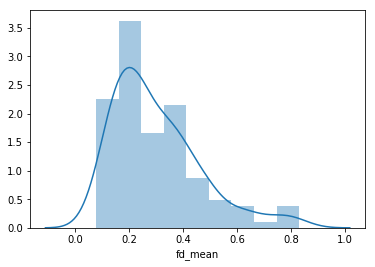

In [6]:
sns.distplot(bold_qa['fd_mean'])

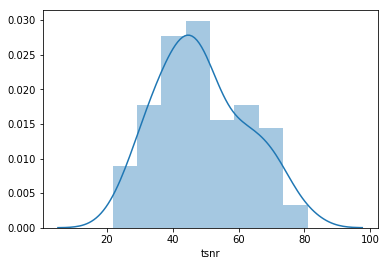

In [7]:
sns.distplot(bold_qa['tsnr'])

In [8]:
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [9]:
# drop the num measurement
bold_qa_select.drop(columns='fd_num', inplace=True)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### load the participants tsv


In [10]:
participant_df = pd.read_csv(PARTICIPANT_DEMO, sep='\t')
participant_df_select = participant_df[["participant_id", "sex", "age", "education"]]
participant_df.head()

participant_id     sex  gender  age  education
0       GE120008  Female  Female   81         12
1       GE120007    Male    Male   83         14
2       GE120045    Male    Male   76         18
3       GE120046    Male    Male   74         21
4       GE120070    Male    Male   71         17

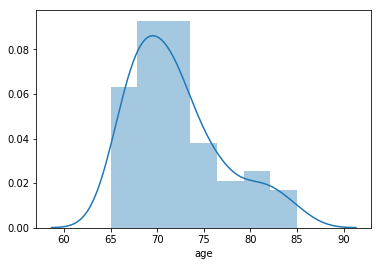

In [11]:
sns.distplot(participant_df['age'])

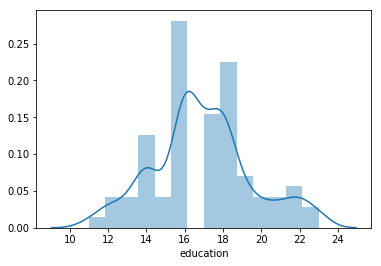

In [12]:
sns.distplot(participant_df['education'])

### Get the correlation files

In [13]:
lss_sch_layout = BIDSLayout(LSS_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lsa_sch_layout = BIDSLayout(LSA_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lss_act_layout = BIDSLayout(LSS_ACT_PATH, validate=False, config=['bids', 'derivatives'])
lsa_act_layout = BIDSLayout(LSA_ACT_PATH, validate=False, config=['bids', 'derivatives'])

In [14]:
ent = lss_sch_layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

In [203]:
# fb=fauxbold, ts=taskswitch
# act=activation, sch=schaefer
# lss=least squares separate, lsa=least squares all
fb_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

fb_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

ts_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

fb_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

ts_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

In [202]:
len(ts_sch_lss_objs['dual'])

40

### Describe Demographics of the used participants

In [17]:
participant_df_select[participant_df_select['participant_id'].isin(ent)].describe(include='all')

participant_id     sex        age  education
count              61      61  61.000000  61.000000
unique             61       2        NaN        NaN
top          GE120028  Female        NaN        NaN
freq                1      31        NaN        NaN
mean              NaN     NaN  71.754098  17.065574
std               NaN     NaN   4.766745   2.657498
min               NaN     NaN  65.000000  12.000000
25%               NaN     NaN  69.000000  16.000000
50%               NaN     NaN  71.000000  17.000000
75%               NaN     NaN  73.000000  18.000000
max               NaN     NaN  85.000000  23.000000

In [18]:
participant_df_select = participant_df_select[participant_df_select['participant_id'].isin(good_participants)]

In [19]:
participant_df_select.describe(include='all')

participant_id     sex        age  education
count              40      40  40.000000  40.000000
unique             40       2        NaN        NaN
top          GE120028  Female        NaN        NaN
freq                1      21        NaN        NaN
mean              NaN     NaN  71.025000  16.950000
std               NaN     NaN   4.514861   2.745159
min               NaN     NaN  65.000000  12.000000
25%               NaN     NaN  68.000000  16.000000
50%               NaN     NaN  69.500000  17.000000
75%               NaN     NaN  72.250000  18.000000
max               NaN     NaN  83.000000  23.000000

## 1. Average within/between network correlations for task and null
I expect both the between and within network correlations to be higher during task, since there is a low likelihood of there being a BOLD response during the resting state data, and beta should not have a good fit for the rest data.
I'm only using the schaefer atlas for this hypothesis to measure the entire cortex.

In [20]:
# summarize the task data
with Pool(N_THREADS) as p:
    ts_dfs = p.starmap(nf.summarize_network_correlations,
                       [(f.path, f.entities['subject']) for f in ts_sch_lss_objs['dual']])
taskswitch_df = pd.concat(ts_dfs)
taskswitch_df.head()

network_connection source_network      mean participant_id
0            between          ContA  0.295485       GE120001
1            between          ContB  0.273729       GE120001
2            between          ContC  0.277209       GE120001
3            between       DefaultA  0.196222       GE120001
4            between       DefaultB  0.186781       GE120001

In [21]:
# summarize the rest data
with Pool(N_THREADS) as p:
    fb_dfs = p.starmap(nf.summarize_network_correlations,
                       [(f.path, f.entities['subject']) for f in fb_sch_lss_objs['dual']])
fauxbold_df = pd.concat(fb_dfs)
fauxbold_df.head()

network_connection source_network      mean participant_id
0            between          ContA  0.170443       GE120001
1            between          ContB  0.168019       GE120001
2            between          ContC  0.172375       GE120001
3            between       DefaultA  0.136658       GE120001
4            between       DefaultB  0.102262       GE120001

In [22]:
# combine taskswitch and fauxbold (task and rest)
taskswitch_df['data'] = ['taskswitch'] * taskswitch_df.shape[0]
fauxbold_df['data'] = ['fauxbold'] * fauxbold_df.shape[0]
data_df = pd.concat([taskswitch_df, fauxbold_df])

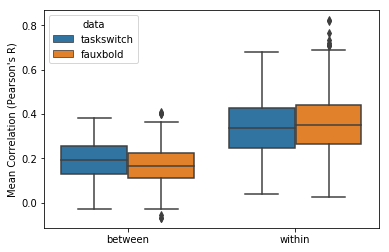

In [23]:
ax = sns.boxplot(x="network_connection", y="mean", hue='data', data=data_df)
ax.set_ylabel("Mean Correlation (Pearson's R)");
ax.set_xlabel("");


In [24]:
if not os.path.isfile("outputs/within_between.eps") or OVERWRITE_IMAGES:
    ax.figure.savefig("outputs/within_between.eps", dpi=1200)

### Overall within/between network correlations do not support hypothesis 1

The average within network correlations turn out to be a little **higher** in rest relative to task, contrary to my hypothesis.
In addition, the average between network correlation does not appear to differ betweentask and rest.

### Split average within/between correlation by network
This will identify whether there are some networks during rest that have higher within network correlations relative to task and some vice versa, or if the pattern is consistent throughout.

In [25]:
g = sns.catplot(kind='box', height=5, aspect=2,
            x='source_network', y='mean', row='network_connection',
            hue='data', data=data_df)

for ax in g.axes.flatten():
    ax.set_ylabel("Mean Correlation (Pearson's R)");

g.axes[1][0].set_xlabel("");
g.axes[1][0].set_xticklabels(g.axes[1][0].get_xticklabels(), rotation=45);


In [26]:
if not os.path.isfile("outputs/within_between_networks.eps") or OVERWRITE_IMAGES:
    g.savefig("outputs/within_between_networks.eps", bbox_inches="tight", dpi=1200)

### Average within/between network correlation do not differ across networks
The rest within network correlations appear **higher** than the task within network correlations across all networks.

## The condition contrast within the task will be greater than the condition contrast within rest
The task had multiple trial types (single, repeat, dual).
If beta series is able to pull out differences between trial types, the difference between dual and repeat during the task should be greater than the difference between "dual" and "repeat" during rest, since no actual events occurred during rest.

In [27]:
# task (dual - repeat)
with Pool(N_THREADS) as p:
    ts_diff_matrices = p.starmap(nf.calc_diff_matrices,
                                 [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(ts_sch_lss_objs['dual'], ts_sch_lss_objs['single'])])

taskswitch_diff = pd.concat(ts_diff_matrices)

In [28]:
# rest (dual - repeat)
with Pool(N_THREADS) as p:
    fb_diff_matrices = p.starmap(nf.calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(fb_sch_lss_objs['dual'], fb_sch_lss_objs['single'])])

fauxbold_diff = pd.concat(fb_diff_matrices)

In [29]:
taskswitch_diff['data'] = ['taskswitch'] * taskswitch_diff.shape[0]
fauxbold_diff['data'] = ['fauxbold'] * fauxbold_diff.shape[0]

In [30]:
diff_dual_repeat = pd.concat([taskswitch_diff, fauxbold_diff])
diff_dual_repeat.head()

index network_connection source_network      mean participant_id    mean_r  \
0      0            between          ContA  0.063441       GE120001  0.063356   
1      1            between          ContB  0.053533       GE120001  0.053482   
2      2            between          ContC -0.010196       GE120001 -0.010195   
3      3            between       DefaultA -0.030010       GE120001 -0.030001   
4      4            between       DefaultB  0.006439       GE120001  0.006439   

         data  
0  taskswitch  
1  taskswitch  
2  taskswitch  
3  taskswitch  
4  taskswitch

In [31]:
fg = sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean_r', row='network_connection', showfliers=False, hue='data', data=diff_dual_repeat)
for ax in fg.axes.flatten():
    ax.axhline(color='red', linestyle='--');
    ax.set_ylabel("Correlation Difference (dual - Single)");

fg.axes[1][0].set_xlabel("");
fg.axes[1][0].set_xticklabels(g.axes[1][0].get_xticklabels(), rotation=45);

In [32]:
if not os.path.isfile("outputs/dual_repeat_difference.eps") or OVERWRITE_IMAGES:
    fg.savefig("outputs/dual_repeat_difference.eps", bbox_inches="tight", dpi=1200)

## 2. The correlation contrast between task and rest will be different from zero


In [33]:
with Pool(N_THREADS) as p:
    tsf_diff_matrices = p.starmap(nf.calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(ts_sch_lss_objs['dual'], fb_sch_lss_objs['dual'])])


task_faux_diff = pd.concat(tsf_diff_matrices)
task_faux_diff.head()

index network_connection source_network      mean participant_id    mean_r
0      0            between          ContA  0.150687       GE120001  0.149556
1      1            between          ContB  0.123586       GE120001  0.122960
2      2            between          ContC  0.117162       GE120001  0.116629
3      3            between       DefaultA  0.067037       GE120001  0.066937
4      4            between       DefaultB  0.092860       GE120001  0.092594

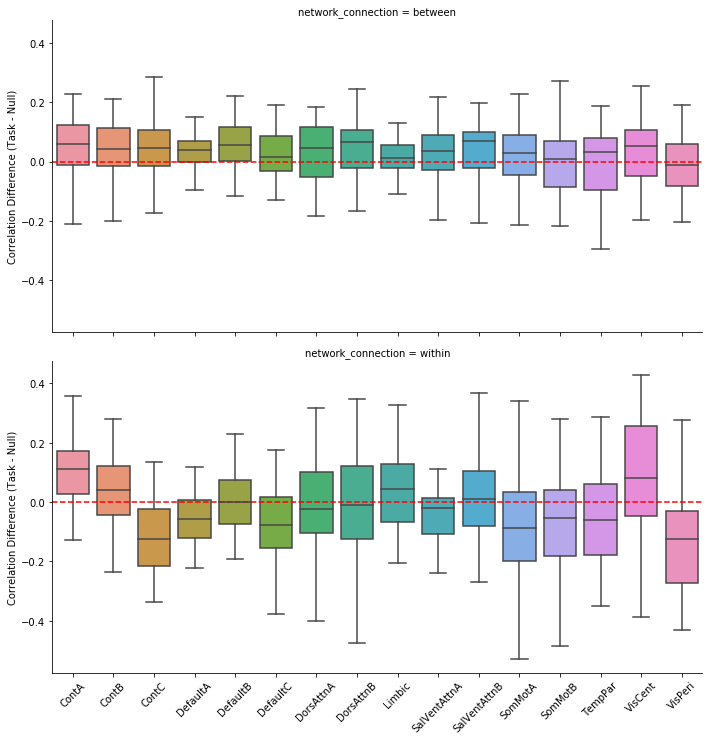

In [34]:
fg = sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean_r', row='network_connection', showfliers=False, data=task_faux_diff)
for ax in fg.axes.flatten():
    ax.axhline(color='red', linestyle='--');
    ax.set_ylabel("Correlation Difference (Task - Null)");

fg.axes[1][0].set_xlabel("");
fg.axes[1][0].set_xticklabels(g.axes[1][0].get_xticklabels(), rotation=45);

In [35]:
if not os.path.isfile("outputs/task_rest_difference.eps") or OVERWRITE_IMAGES:
    fg.savefig("outputs/task_rest_difference.eps", bbox_inches="tight", dpi=600)

## model correlation differences between task and null

In [36]:
dual_wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['dual'], 'taskswitch'), nf.bind_matrices(fb_sch_lss_objs['dual'], 'fauxbold')])
dual_wide_df.head()

LH-VisCent-ExStr_1__LH-VisCent-ExStr_2  \
0                                0.455432   
1                                1.212133   
2                                0.190419   
3                                1.005205   
4                                1.644929   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_3  \
0                                1.662070   
1                                1.428456   
2                                0.655153   
3                                0.754942   
4                                0.984784   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_4  \
0                                0.909218   
1                                1.257984   
2                                1.113389   
3                                1.116893   
4                                0.934502   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_5  \
0                                0.797212   
1                                0.773310   
2                                0.586957   
3                                0.953361   
4                                1.222828   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_6  \
0                                1.015415   
1                                1.115010   
2                                0.344697   
3                                0.908690   
4                                1.271788   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_7  \
0                                0.779507   
1                                0.750861   
2                                0.901645   
3                                0.930372   
4                                0.840875   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_8  \
0                                0.465322   
1                                0.705674   
2                                0.276109   
3                               -0.086483   
4                                1.366996   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_9  \
0                                0.831231   
1                                0.631698   
2                                0.089652   
3                                0.375611   
4                                1.332187   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_10  \
0                                 0.046395   
1                                 0.473016   
2                                 0.574456   
3                                 0.205547   
4                                 0.877549   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_11  ...  RH-TempPar-6__RH-TempPar-9  \
0                                 0.252555  ...                    0.302543   
1                                -0.276409  ...                    0.673559   
2                                 0.203179  ...                    0.110943   
3                                 0.013893  ...                    0.634429   
4                                 0.383066  ...                    1.033700   

   RH-TempPar-6__RH-TempPar-10  RH-TempPar-7__RH-TempPar-8  \
0                     0.073175                    0.555606   
1                     0.347598                    1.224006   
2                     0.335138                    0.755747   
3                    -0.255407                    0.948538   
4                     0.242665                    1.215956   

   RH-TempPar-7__RH-TempPar-9  RH-TempPar-7__RH-TempPar-10  \
0                    0.384526                     0.040054   
1                    0.813738                     0.385667   
2                    0.125890                    -0.050883   
3                    0.768878                    -0.140858   
4                    0.687100                     0.419498   

   RH-TempPar-8__RH-TempPar-9  RH-TempPar-8__RH-TempPar-10  \
0                    0.621641                     0.347325   
1                    0.861109                     0.568730   
2                    0.277814                     0.108394   
3                    1.249150                     0.278178   
4                    0.5477

In [37]:
# bind qa measures
dual_wide_nr_df = pd.merge(dual_wide_df, bold_qa_select, how='left', on=['participant_id', 'task'])
dual_wide_nr_df = pd.merge(dual_wide_nr_df, participant_df_select, how='left', on=['participant_id'])

### Do not include nuisance regressors

In [38]:
model_df = nf.model_corr_diff_mt(dual_wide_df, N_THREADS)

In [39]:
p_value_df = nf.make_symmetric_df(model_df, "p_value")
estimate_df = nf.make_symmetric_df(model_df, "estimate")
display(p_value_df.head())
display(estimate_df.head())

ContA-LH_Cinga_1  ContA-LH_IPS_1  ContA-LH_IPS_2  \
ContA-LH_Cinga_1          0.000000        0.776983        0.787258   
ContA-LH_IPS_1            0.776983        0.000000        0.063228   
ContA-LH_IPS_2            0.787258        0.063228        0.000000   
ContA-LH_IPS_3            0.480496        0.000129        0.055301   
ContA-LH_IPS_4            0.104615        0.005677        0.081766   

                  ContA-LH_IPS_3  ContA-LH_IPS_4  ContA-LH_IPS_5  \
ContA-LH_Cinga_1        0.480496        0.104615        0.378413   
ContA-LH_IPS_1          0.000129        0.005677        0.000401   
ContA-LH_IPS_2          0.055301        0.081766        0.276395   
ContA-LH_IPS_3          0.000000        0.000889        0.001950   
ContA-LH_IPS_4          0.000889        0.000000        0.424346   

                  ContA-LH_PFCd_1  ContA-LH_PFCl_1  ContA-LH_PFCl_2  \
ContA-LH_Cinga_1         0.797324         0.346724         0.326001   
ContA-LH_IPS_1           0.928285         0.001678         0.015206   
ContA-LH_IPS_2           0.700144         0.064873         0.125393   
ContA-LH_IPS_3           0.712777         0.002007         0.001585   
ContA-LH_IPS_4           0.615794         0.000555         0.000087   

                  ContA-LH_PFCl_3  ...  VisPeri-RH_ExStrSup_10  \
ContA-LH_Cinga_1         0.810170  ...                0.521116   
ContA-LH_IPS_1           0.000388  ...                0.720095   
ContA-LH_IPS_2           0.000302  ...                0.851829   
ContA-LH_IPS_3           0.004467  ...                0.927433   
ContA-LH_IPS_4           0.001219  ...                0.712332   

                  VisPeri-RH_ExStrSup_11  VisPeri-RH_ExStrSup_2  \
ContA-LH_Cinga_1                0.169061               0.580052   
ContA-LH_IPS_1                  0.132880               0.952560   
ContA-LH_IPS_2                  0.160866               0.462347   
ContA-LH_IPS_3                  0.050792               0.746888   
ContA-LH_IPS_4                  0.077722               0.179856   

                  VisPeri-RH_ExStrSup_3  VisPeri-RH_ExStrSup_4  \
ContA-LH_Cinga_1               0.821390               0.942524   
ContA-LH_IPS_1                 0.679752               0.342168   
ContA-LH_IPS_2                 0.220934               0.319064   
ContA-LH_IPS_3                 0.518414               0.937586   
ContA-LH_IPS_4                 0.136622               0.890061   

                  VisPeri-RH_ExStrSup_5  VisPeri-RH_ExStrSup_6  \
ContA-LH_Cinga_1               0.767907               0.749049   
ContA-LH_IPS_1                 0.444407               0.490300   
ContA-LH_IPS_2                 0.741564               0.813525   
ContA-LH_IPS_3                 0.815049               0.080477   
ContA-LH_IPS_4                 0.813016               0.016387   

                  VisPeri-RH_ExStrSup_7  VisPeri-RH_ExStrSup_8  \
ContA-LH_Cinga_1               0.608415               0.969037   
ContA-LH_IPS_1                 0.593371               0.357671   
ContA-LH_IPS_2                 0.978040               0.931395   
ContA-LH_IPS_3                 0.519935               0.796955   
ContA-LH_IPS_4                 0.821763               0.805702   

                  VisPeri-RH_ExStrSup_9  
ContA-LH_Cinga_1               0.871350  
ContA-LH_IPS_1                 0.701664  
ContA-LH_IPS_2                 0.205312  
ContA-LH_IPS_3                 0.010979  
ContA-LH_IPS_4                 0.049255  

[5 rows x 400 columns]

ContA-LH_Cinga_1  ContA-LH_IPS_1  ContA-LH_IPS_2  \
ContA-LH_Cinga_1          0.000000       -0.017020        0.018977   
ContA-LH_IPS_1           -0.017020        0.000000        0.117633   
ContA-LH_IPS_2            0.018977        0.117633        0.000000   
ContA-LH_IPS_3           -0.044275        0.293864        0.142782   
ContA-LH_IPS_4            0.100541        0.207267        0.129708   

                  ContA-LH_IPS_3  ContA-LH_IPS_4  ContA-LH_IPS_5  \
ContA-LH_Cinga_1       -0.044275        0.100541        0.052791   
ContA-LH_IPS_1          0.293864        0.207267        0.248889   
ContA-LH_IPS_2          0.142782        0.129708        0.070420   
ContA-LH_IPS_3          0.000000        0.231079        0.227276   
ContA-LH_IPS_4          0.231079        0.000000        0.055744   

                  ContA-LH_PFCd_1  ContA-LH_PFCl_1  ContA-LH_PFCl_2  \
ContA-LH_Cinga_1        -0.015507        -0.067951        -0.069593   
ContA-LH_IPS_1          -0.005101         0.233682         0.179137   
ContA-LH_IPS_2          -0.022869         0.146258         0.121224   
ContA-LH_IPS_3           0.021960         0.266630         0.281475   
ContA-LH_IPS_4           0.033977         0.286049         0.361609   

                  ContA-LH_PFCl_3  ...  VisPeri-RH_ExStrSup_10  \
ContA-LH_Cinga_1        -0.018230  ...                0.044648   
ContA-LH_IPS_1           0.285323  ...                0.021165   
ContA-LH_IPS_2           0.297719  ...                0.012810   
ContA-LH_IPS_3           0.238053  ...                0.006593   
ContA-LH_IPS_4           0.272416  ...                0.026072   

                  VisPeri-RH_ExStrSup_11  VisPeri-RH_ExStrSup_2  \
ContA-LH_Cinga_1               -0.097216              -0.038215   
ContA-LH_IPS_1                  0.114056              -0.003328   
ContA-LH_IPS_2                  0.102607               0.052520   
ContA-LH_IPS_3                  0.145297               0.020784   
ContA-LH_IPS_4                  0.144446               0.090069   

                  VisPeri-RH_ExStrSup_3  VisPeri-RH_ExStrSup_4  \
ContA-LH_Cinga_1              -0.014726              -0.005148   
ContA-LH_IPS_1                -0.024425              -0.052969   
ContA-LH_IPS_2                 0.070307               0.056449   
ContA-LH_IPS_3                 0.037640               0.005026   
ContA-LH_IPS_4                 0.090225              -0.008487   

                  VisPeri-RH_ExStrSup_5  VisPeri-RH_ExStrSup_6  \
ContA-LH_Cinga_1              -0.020620               0.018210   
ContA-LH_IPS_1                -0.044582               0.037180   
ContA-LH_IPS_2                 0.021282               0.013148   
ContA-LH_IPS_3                 0.016430               0.101148   
ContA-LH_IPS_4                 0.017013               0.139480   

                  VisPeri-RH_ExStrSup_7  VisPeri-RH_ExStrSup_8  \
ContA-LH_Cinga_1               0.035522               0.002334   
ContA-LH_IPS_1                -0.031011              -0.053719   
ContA-LH_IPS_2                -0.001643              -0.004967   
ContA-LH_IPS_3                 0.037367               0.014411   
ContA-LH_IPS_4                 0.014850               0.013687   

                  VisPeri-RH_ExStrSup_9  
ContA-LH_Cinga_1              -0.009514  
ContA-LH_IPS_1                 0.021107  
ContA-LH_IPS_2                 0.074577  
ContA-LH_IPS_3                 0.141525  
ContA-LH_IPS_4                 0.117690  

[5 rows x 400 columns]

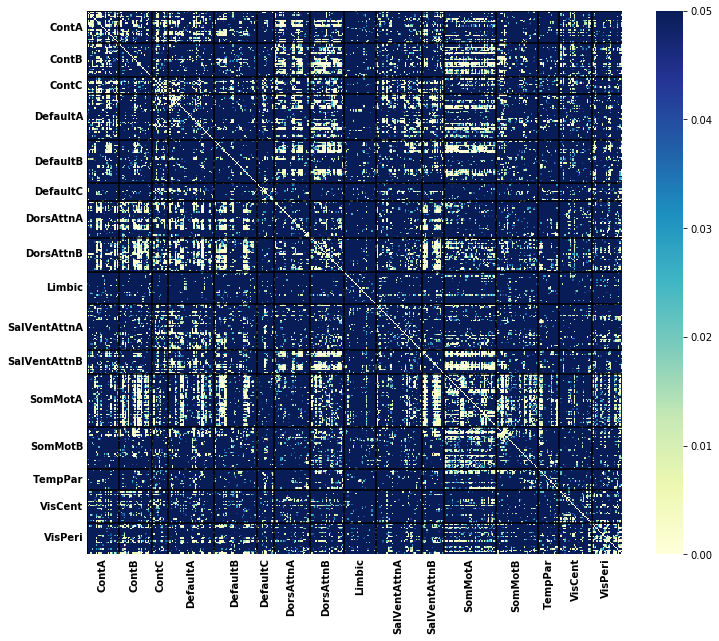

In [40]:
f = nf._make_pretty_schaefer_heatmap(p_value_df, vmin=0.0, vmax=0.05, cmap="YlGnBu")

In [41]:
if not os.path.isfile("outputs/task_null_difference_heatmap_pval.eps") or OVERWRITE_IMAGES:
    f.savefig("outputs/task_null_difference_heatmap_pval.eps", bbox_inches="tight", dpi=600)

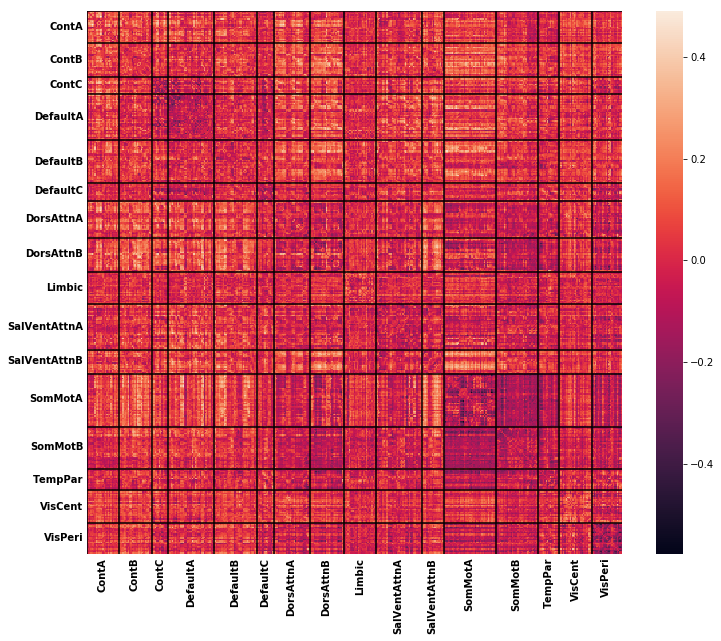

In [42]:
f = nf._make_pretty_schaefer_heatmap(estimate_df)

In [43]:
if not os.path.isfile("outputs/task_rest_difference_heatmap_estimates.eps") or OVERWRITE_IMAGES:
    f.savefig("outputs/task_rest_difference_heatmap_estimates.eps", bbox_inches="tight", dpi=600)

In [44]:
idxs = np.triu_indices(p_value_df.shape[0], k=1)
# false discovery rate (Benjamini/Hochberg)
p_values_sig, p_value_fdr, _, _ = multipletests(p_value_df.values[idxs], alpha=0.05, method='fdr_bh')
# show the fdr corrected values
p_value_fdr[p_values_sig]

array([0.04814152, 0.0474435 , 0.0077079 , ..., 0.01323845, 0.00286464,
       0.01581718])

In [45]:
p_value_fdr[p_values_sig].shape

(4677,)

### Include framewise displacement, tsnr, age, sex, and education

In [46]:
model_nr_df = nf.model_corr_diff_mt(dual_wide_nr_df, N_THREADS, ['fd_mean', 'tsnr', 'age', 'sex', 'education'])

In [47]:
p_value_nr_df = nf.make_symmetric_df(model_nr_df, "p_value")
estimate_nr_df = nf.make_symmetric_df(model_nr_df, "estimate")
display(p_value_nr_df.head())
display(estimate_nr_df.head())

ContA-LH_Cinga_1  ContA-LH_IPS_1  ContA-LH_IPS_2  \
ContA-LH_Cinga_1          0.000000        0.759799        0.351851   
ContA-LH_IPS_1            0.759799        0.000000        0.076259   
ContA-LH_IPS_2            0.351851        0.076259        0.000000   
ContA-LH_IPS_3            0.979705        0.000411        0.025182   
ContA-LH_IPS_4            0.014871        0.024377        0.060063   

                  ContA-LH_IPS_3  ContA-LH_IPS_4  ContA-LH_IPS_5  \
ContA-LH_Cinga_1        0.979705        0.014871        0.270834   
ContA-LH_IPS_1          0.000411        0.024377        0.002017   
ContA-LH_IPS_2          0.025182        0.060063        0.127675   
ContA-LH_IPS_3          0.000000        0.000301        0.002046   
ContA-LH_IPS_4          0.000301        0.000000        0.452520   

                  ContA-LH_PFCd_1  ContA-LH_PFCl_1  ContA-LH_PFCl_2  \
ContA-LH_Cinga_1         0.901085         0.257842         0.101057   
ContA-LH_IPS_1           0.734776         0.003891         0.044935   
ContA-LH_IPS_2           0.998953         0.230897         0.546731   
ContA-LH_IPS_3           0.485952         0.007090         0.007021   
ContA-LH_IPS_4           0.414462         0.001153         0.000773   

                  ContA-LH_PFCl_3  ...  VisPeri-RH_ExStrSup_10  \
ContA-LH_Cinga_1         0.681799  ...                0.270756   
ContA-LH_IPS_1           0.001217  ...                0.610827   
ContA-LH_IPS_2           0.005300  ...                0.484962   
ContA-LH_IPS_3           0.019205  ...                0.527049   
ContA-LH_IPS_4           0.005165  ...                0.392725   

                  VisPeri-RH_ExStrSup_11  VisPeri-RH_ExStrSup_2  \
ContA-LH_Cinga_1                0.318006               0.252801   
ContA-LH_IPS_1                  0.031877               0.930260   
ContA-LH_IPS_2                  0.093751               0.431512   
ContA-LH_IPS_3                  0.030354               0.686213   
ContA-LH_IPS_4                  0.116375               0.217040   

                  VisPeri-RH_ExStrSup_3  VisPeri-RH_ExStrSup_4  \
ContA-LH_Cinga_1               0.903753               0.957515   
ContA-LH_IPS_1                 0.475519               0.276326   
ContA-LH_IPS_2                 0.135589               0.324050   
ContA-LH_IPS_3                 0.776602               0.670996   
ContA-LH_IPS_4                 0.175200               0.747397   

                  VisPeri-RH_ExStrSup_5  VisPeri-RH_ExStrSup_6  \
ContA-LH_Cinga_1               0.996452               0.539835   
ContA-LH_IPS_1                 0.225610               0.944019   
ContA-LH_IPS_2                 0.740169               0.628318   
ContA-LH_IPS_3                 0.742613               0.133941   
ContA-LH_IPS_4                 0.820358               0.014425   

                  VisPeri-RH_ExStrSup_7  VisPeri-RH_ExStrSup_8  \
ContA-LH_Cinga_1               0.697585               0.683913   
ContA-LH_IPS_1                 0.209905               0.416515   
ContA-LH_IPS_2                 0.617900               0.711285   
ContA-LH_IPS_3                 0.621121               0.533422   
ContA-LH_IPS_4                 0.595258               0.484750   

                  VisPeri-RH_ExStrSup_9  
ContA-LH_Cinga_1               0.897515  
ContA-LH_IPS_1                 0.937803  
ContA-LH_IPS_2                 0.485187  
ContA-LH_IPS_3                 0.041312  
ContA-LH_IPS_4                 0.156761  

[5 rows x 400 columns]

ContA-LH_Cinga_1  ContA-LH_IPS_1  ContA-LH_IPS_2  \
ContA-LH_Cinga_1          0.000000       -0.020290        0.069912   
ContA-LH_IPS_1           -0.020290        0.000000        0.119343   
ContA-LH_IPS_2            0.069912        0.119343        0.000000   
ContA-LH_IPS_3           -0.001692        0.281162        0.176458   
ContA-LH_IPS_4            0.155134        0.175151        0.150639   

                  ContA-LH_IPS_3  ContA-LH_IPS_4  ContA-LH_IPS_5  \
ContA-LH_Cinga_1       -0.001692        0.155134        0.070669   
ContA-LH_IPS_1          0.281162        0.175151        0.228077   
ContA-LH_IPS_2          0.176458        0.150639        0.107372   
ContA-LH_IPS_3          0.000000        0.257720        0.244635   
ContA-LH_IPS_4          0.257720        0.000000        0.053601   

                  ContA-LH_PFCd_1  ContA-LH_PFCl_1  ContA-LH_PFCl_2  \
ContA-LH_Cinga_1        -0.008194        -0.087951        -0.122804   
ContA-LH_IPS_1           0.017632         0.224469         0.153697   
ContA-LH_IPS_2           0.000083         0.096292         0.048105   
ContA-LH_IPS_3           0.038797         0.240554         0.240031   
ContA-LH_IPS_4           0.054291         0.273424         0.313981   

                  ContA-LH_PFCl_3  ...  VisPeri-RH_ExStrSup_10  \
ContA-LH_Cinga_1        -0.034105  ...                0.082607   
ContA-LH_IPS_1           0.272685  ...                0.032327   
ContA-LH_IPS_2           0.235576  ...                0.050794   
ContA-LH_IPS_3           0.195862  ...                0.044577   
ContA-LH_IPS_4           0.237709  ...                0.061117   

                  VisPeri-RH_ExStrSup_11  VisPeri-RH_ExStrSup_2  \
ContA-LH_Cinga_1               -0.075664              -0.084708   
ContA-LH_IPS_1                  0.174953               0.005362   
ContA-LH_IPS_2                  0.134179               0.060414   
ContA-LH_IPS_3                  0.174108               0.028591   
ContA-LH_IPS_4                  0.140740               0.089535   

                  VisPeri-RH_ExStrSup_3  VisPeri-RH_ExStrSup_4  \
ContA-LH_Cinga_1               0.008373              -0.003996   
ContA-LH_IPS_1                -0.044041              -0.064602   
ContA-LH_IPS_2                 0.089837               0.061538   
ContA-LH_IPS_3                 0.016433              -0.027799   
ContA-LH_IPS_4                 0.085968              -0.020879   

                  VisPeri-RH_ExStrSup_5  VisPeri-RH_ExStrSup_6  \
ContA-LH_Cinga_1               0.000329               0.036060   
ContA-LH_IPS_1                -0.072518               0.004000   
ContA-LH_IPS_2                -0.022448               0.028491   
ContA-LH_IPS_3                -0.023958               0.089416   
ContA-LH_IPS_4                -0.016260               0.147535   

                  VisPeri-RH_ExStrSup_7  VisPeri-RH_ExStrSup_8  \
ContA-LH_Cinga_1               0.029050               0.026815   
ContA-LH_IPS_1                -0.073501              -0.050868   
ContA-LH_IPS_2                -0.032287               0.022327   
ContA-LH_IPS_3                -0.027554               0.035858   
ContA-LH_IPS_4                -0.033729               0.039125   

                  VisPeri-RH_ExStrSup_9  
ContA-LH_Cinga_1               0.008035  
ContA-LH_IPS_1                -0.004576  
ContA-LH_IPS_2                 0.044174  
ContA-LH_IPS_3                 0.119249  
ContA-LH_IPS_4                 0.085355  

[5 rows x 400 columns]

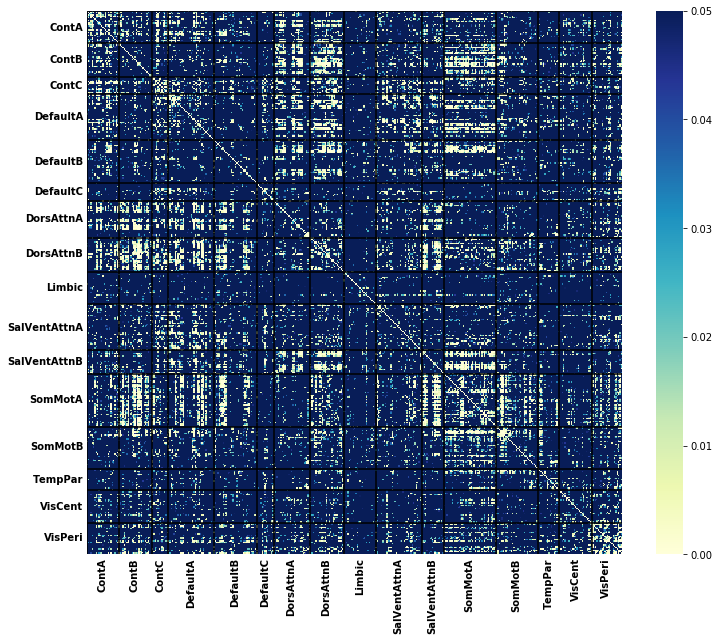

In [48]:
f = nf._make_pretty_schaefer_heatmap(p_value_nr_df, vmin=0.0, vmax=0.05, cmap="YlGnBu")

In [49]:
# false discovery rate (Benjamini/Hochberg)
p_values_sig, p_value_fdr, _, _ = multipletests(p_value_nr_df.values[idxs], alpha=0.05, method='fdr_bh')
# still significant differences...
display(p_value_fdr[p_values_sig].shape)


(3474,)

## 3. The correlation contrasts between task/null, dual/single, repeat/single, and dual/repeat will have more positives using LSS relative to LSA.

In [50]:
# collect permutations and number of significant values found for each condition
permutation_collector = {
    'atlas': [],
    'data': [],
    'contrast': [],
    'estimator': [],
    'participants': [],
    'permutations': [],
    'observed_value': [],
    'p_value': [],
    'binom_p_value': [],
}

In [51]:
# regions with the best CNR
import pickle
with open('outputs/schaefer_best_cnr.pkl', "rb") as fp:
    best_regions_orig = pickle.load(fp)
best_regions = [nf._flip_hemisphere_network(w) for w in best_regions_orig]
best_regions

['VisCent-LH_ExStr_7',
 'VisCent-RH_ExStr_4',
 'Limbic-LH_TempPole_2',
 'Limbic-RH_TempPole_5',
 'Limbic-LH_OFC_3',
 'VisCent-RH_ExStr_7',
 'VisCent-RH_ExStr_9',
 'Limbic-RH_OFC_3',
 'Limbic-LH_TempPole_7',
 'DefaultA-LH_PCC_6',
 'VisCent-RH_ExStr_6',
 'ContA-LH_IPS_1',
 'VisCent-LH_ExStr_4',
 'Limbic-RH_OFC_5',
 'DefaultC-LH_PHC_1',
 'VisCent-LH_ExStr_3',
 'VisCent-RH_ExStr_5',
 'VisPeri-LH_ExStrSup_6',
 'VisCent-LH_ExStr_5',
 'VisCent-RH_ExStr_2']

In [52]:
# for making activation atlas glass brain images
coords_df = pd.read_csv('../firstLevelAnalysis/outputs/cluster_table.tsv', sep='\t')

###  Schaefer Atlas: task - null

Number of Positives lsa: 12129 / 79800
Number of Positives lss: 18883 / 79800
Number of overlapping positives: 7570 / 79800


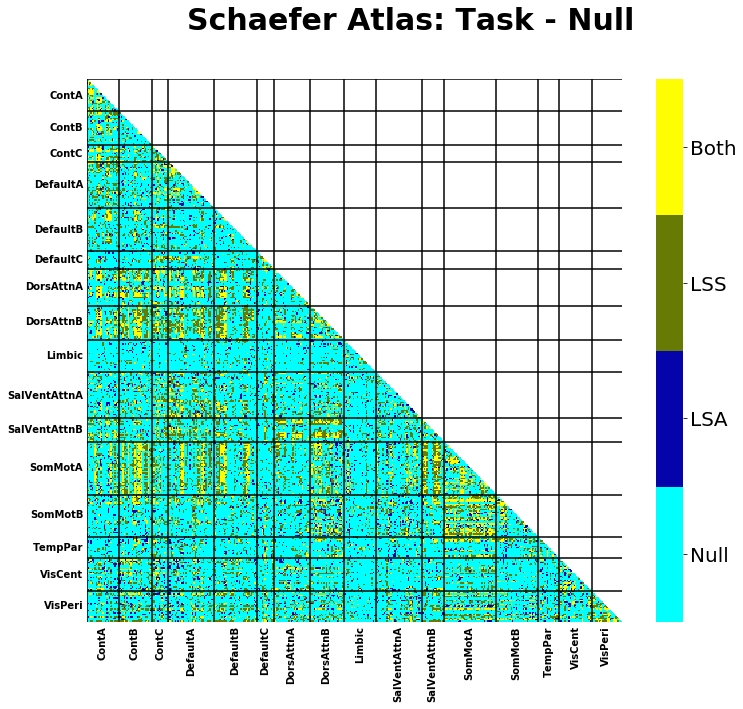

In [53]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['dual'],
                       fb_sch_lss_objs['dual'],
                       ts_sch_lsa_objs['dual'],
                       fb_sch_lsa_objs['dual'],
                       'task', 'null',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_atlas-schaefer_contrast-taskXnull.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

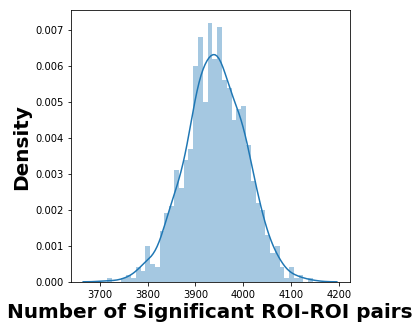

In [54]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-taskxnull_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_sch_lss_objs['dual'], fb_sch_lss_objs['dual'],
        'task', 'null', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)) // 10, ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [55]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
binom_pvalue

0.0

In [56]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)
permutation_collector['binom_p_value'].append(binom_pvalue)

0.0

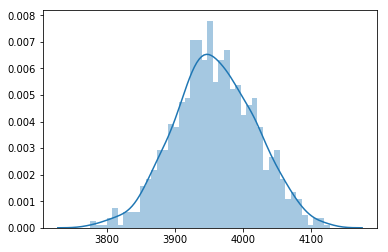

In [57]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-taskxnull_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_sch_lsa_objs['dual'], fb_sch_lsa_objs['dual'],
        'task', 'null', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)) // 10)
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [58]:
binom_pvalue = binom_test(num_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger')
binom_pvalue

0.0

In [59]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)
permutation_collector['binom_p_value'].append(binom_pvalue)

In [60]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

46

In [61]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

22

In [62]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

34

0.0

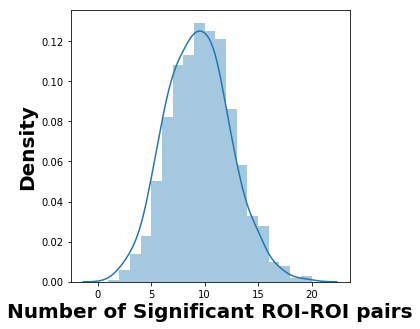

In [63]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-taskxnull_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['dual'], 'task', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lss_objs['dual'], 'null', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [64]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
binom_pvalue

3.332542794403185e-07

In [65]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)
permutation_collector['binom_p_value'].append(binom_pvalue)

0.0

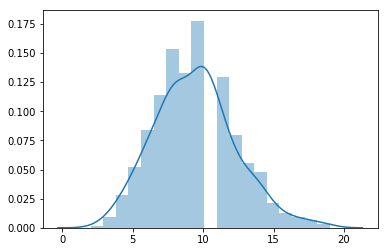

In [66]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-taskxnull_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lsa_objs['dual'], 'task', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lsa_objs['dual'], 'null', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)))
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [67]:
binom_pvalue = binom_test(num_sig, len(lsa_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
binom_pvalue

1.0637788370643805e-14

In [68]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)
permutation_collector['binom_p_value'].append(binom_pvalue)

### Test significance of pairs of correlations

In [69]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(7316,)

In [70]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(1407,)

###  Activation Atlas: task - null

Number of Positives lsa: 25 / 210
Number of Positives lss: 27 / 210
Number of overlapping positives: 10 / 210


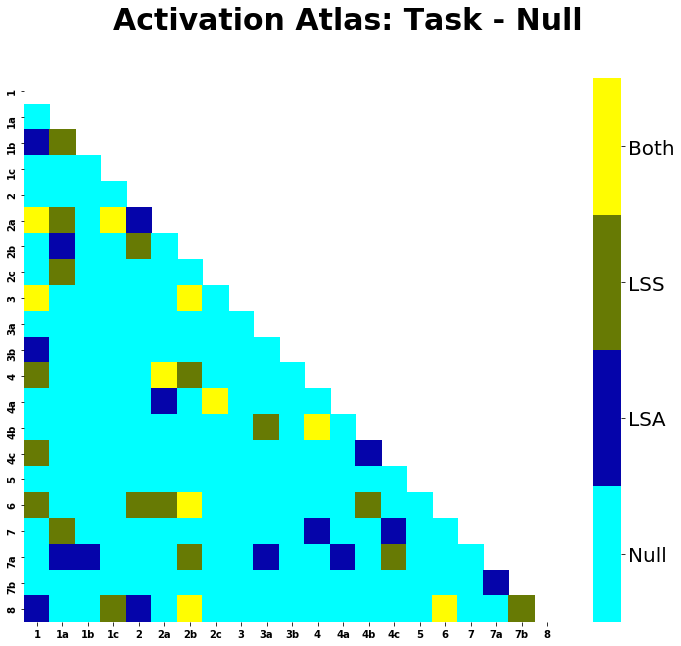

In [71]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['dual'],
                       fb_act_lss_objs['dual'],
                       ts_act_lsa_objs['dual'],
                       fb_act_lsa_objs['dual'],
                       'task', 'null',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_atlas-activation_contrast-taskXnull'
save_eps(fig, outfile)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(axes, collections.Sequence):


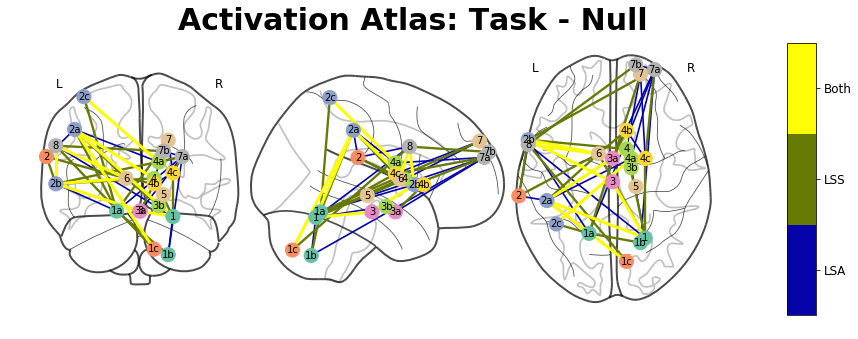

In [72]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_type-brain_atlas-activation_contrast-taskXnull'
save_eps(fig, outfile)

In [73]:
fig.suptitle("")
save_eps(fig, outfile + '_separate')

0.0

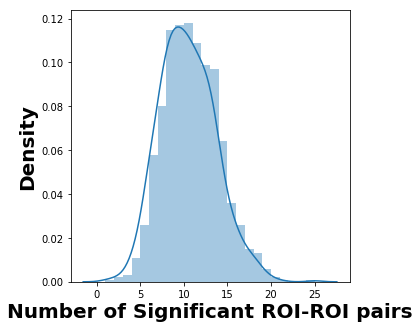

In [74]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-taskxnull_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['dual'], fb_act_lss_objs['dual'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [75]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
binom_pvalue

7.564674360031942e-06

In [76]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)
permutation_collector['binom_p_value'].append(binom_pvalue)

0.0

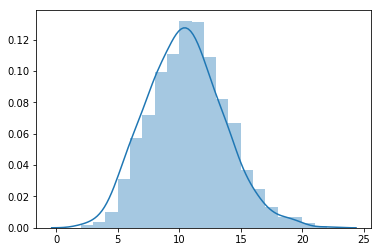

In [77]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-taskxnull_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['dual'], fb_act_lsa_objs['dual'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [78]:
binom_pvalue = binom_test(num_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger')
binom_pvalue

5.885492478354306e-05

In [79]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)
permutation_collector['binom_p_value'].append(binom_pvalue)

### Test significance of pairs of correlations

In [80]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_model_df[lss_sig_array])
display(lss_fdr_pvalues[lss_sig_array].shape)

p_value  estimate source_target source target
136  0.000021  -4.83839        1a__1b     1a     1b

(1,)

In [81]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_model_df[lsa_sig_array])
display(lsa_fdr_pvalues[lsa_sig_array].shape)

Empty DataFrame
Columns: [p_value, estimate, source_target, source, target]
Index: []

(0,)

LSS has one result that survives FDR correction whereas LSA has no results that survive 

### Schaefer Atlas: dual - single (task)

Number of Positives lsa: 8069 / 79800
Number of Positives lss: 7723 / 79800
Number of overlapping positives: 1527 / 79800


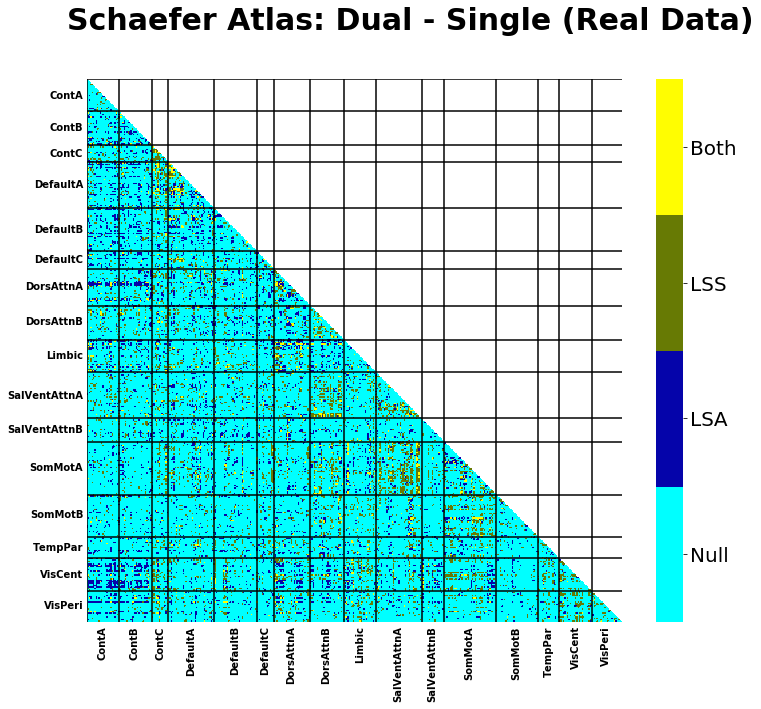

In [82]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['dual'],
                       ts_sch_lss_objs['single'],
                       ts_sch_lsa_objs['dual'],
                       ts_sch_lsa_objs['single'],
                       'dual', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Dual - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-dualXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

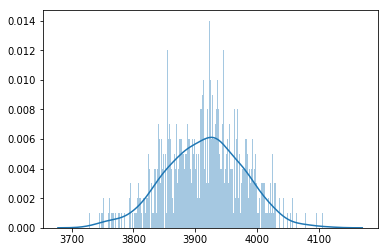

In [83]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_sch_lss_objs['dual'], ts_sch_lss_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [84]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
binom_pvalue

0.0

In [85]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)
permutation_collector['binom_p_value'].append(binom_pvalue)

0.0

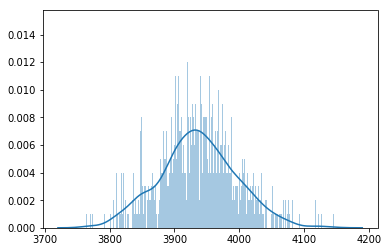

In [86]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_sch_lsa_objs['dual'], ts_sch_lsa_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [87]:
binom_pvalue = binom_test(num_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger')
binom_pvalue

0.0

In [88]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)
permutation_collector['binom_p_value'].append(binom_pvalue)

In [89]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

26

In [90]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

36

In [91]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

4

0.001

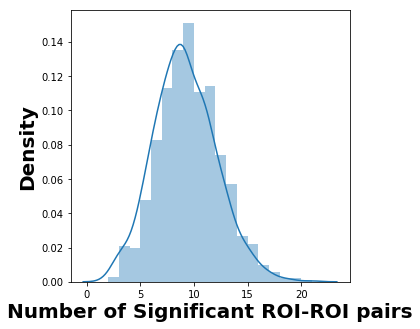

In [92]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['dual'], 'dual', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lss_objs['single'], 'single', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [93]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.001452793502858055

In [94]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.048

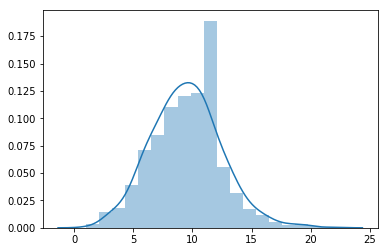

In [95]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lsa_objs['dual'], 'dual', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lsa_objs['single'], 'single', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)))
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [96]:
binom_pvalue = binom_test(num_sig, len(lsa_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.05520896077766845

In [97]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [98]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(29,)

In [99]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(20,)

### Schaefer Atlas: dual - single (null)

Number of Positives lsa: 6384 / 79800
Number of Positives lss: 8213 / 79800
Number of overlapping positives: 1643 / 79800


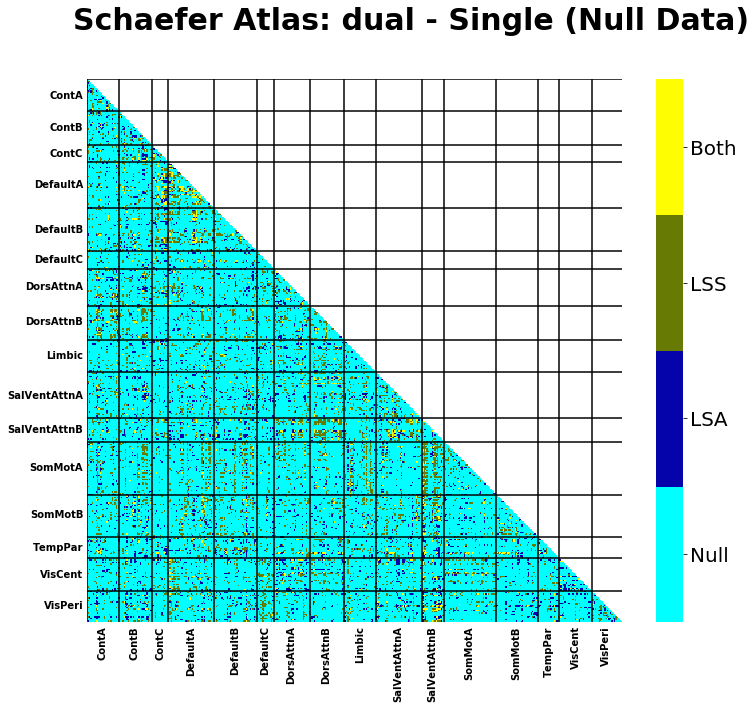

In [100]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['dual'],
                       fb_sch_lss_objs['single'],
                       fb_sch_lsa_objs['dual'],
                       fb_sch_lsa_objs['single'],
                       'dual', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Dual - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-dualXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

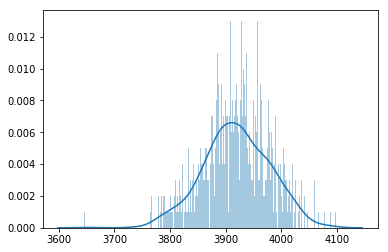

In [101]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_sch_lss_objs['dual'], fb_sch_lss_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [102]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.0

In [103]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

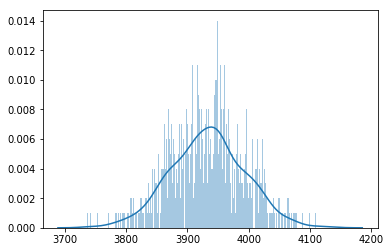

In [104]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_sch_lsa_objs['dual'], fb_sch_lsa_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [105]:
binom_pvalue = binom_test(num_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

1.339624110478928e-282

In [106]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [107]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

34

In [108]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

14

In [109]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

0

0.845

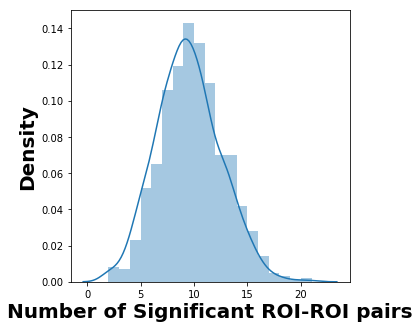

In [110]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lss_objs['dual'], 'dual', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lss_objs['single'], 'single', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [111]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.8418625230327739

In [112]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.011

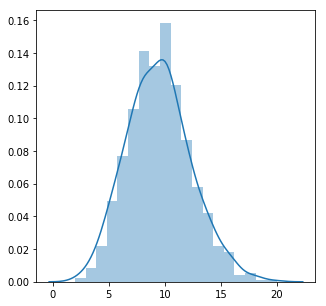

In [113]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lsa_objs['dual'], 'dual', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lsa_objs['single'], 'single', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [114]:
binom_pvalue = binom_test(num_sig, len(lsa_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.015205902859779177

In [115]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [116]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(1,)

In [117]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: dual - single (task)

Number of Positives lsa: 9 / 210
Number of Positives lss: 19 / 210
Number of overlapping positives: 2 / 210


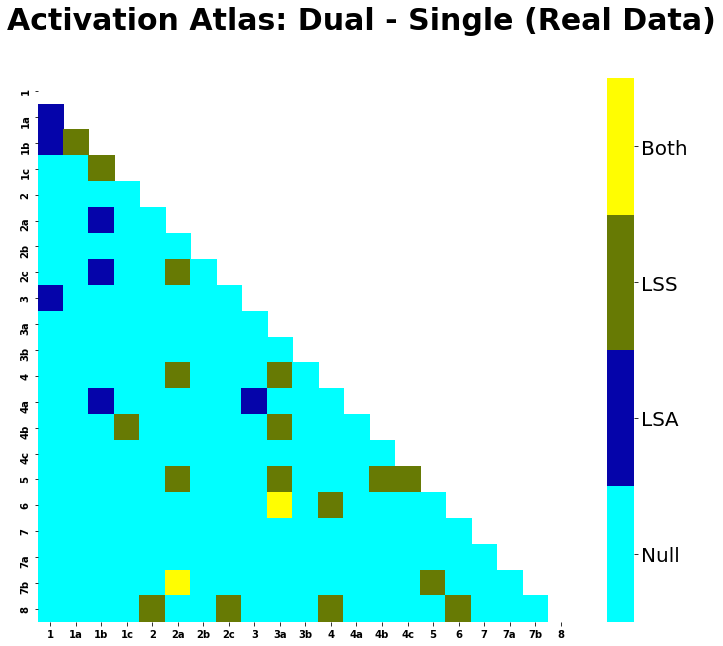

In [118]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['dual'],
                       ts_act_lss_objs['single'],
                       ts_act_lsa_objs['dual'],
                       ts_act_lsa_objs['single'],
                       'dual', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Dual - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-dualXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

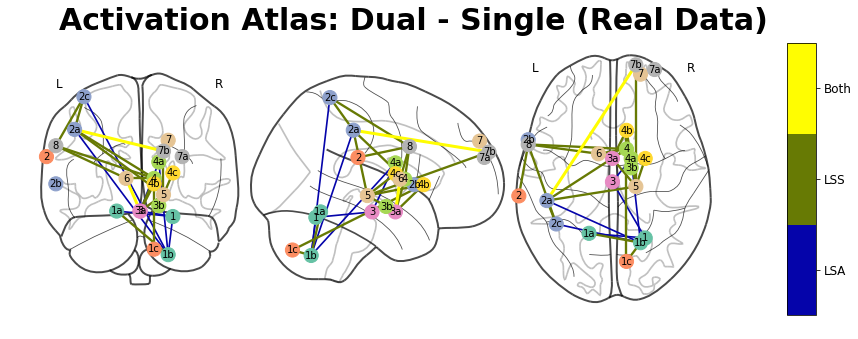

In [119]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Dual - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-dualXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

#### Permutation test to see if number of significant results is expected

0.008

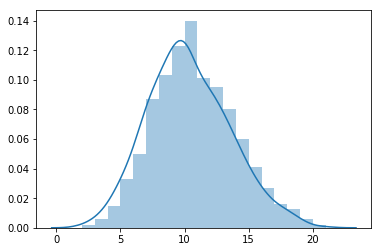

In [120]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['dual'], ts_act_lss_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [121]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.009621225849759765

In [122]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.731

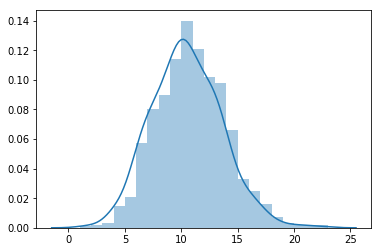

In [123]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['dual'], ts_act_lsa_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [124]:
binom_pvalue = binom_test(num_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.7270661413238029

In [125]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [126]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [127]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: dual - single (null)

Number of Positives lsa: 11 / 210
Number of Positives lss: 9 / 210
Number of overlapping positives: 1 / 210


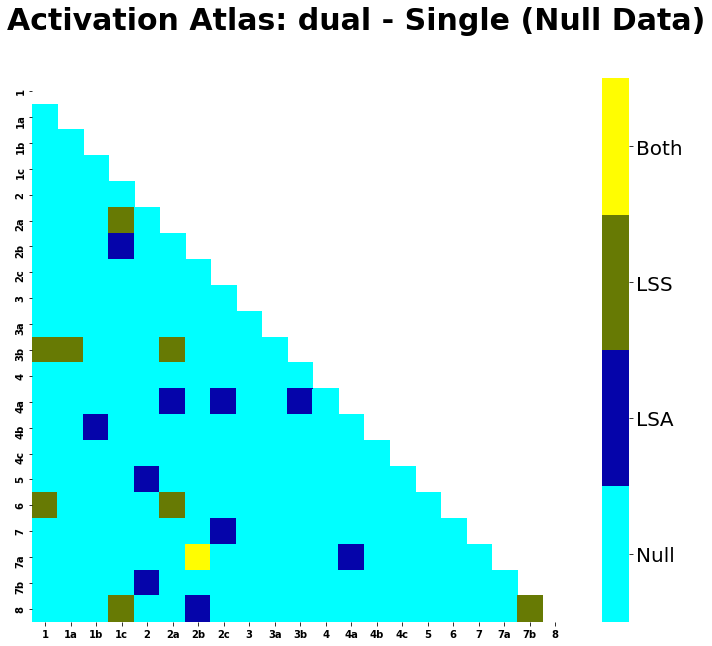

In [128]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['dual'],
                       fb_act_lss_objs['single'],
                       fb_act_lsa_objs['dual'],
                       fb_act_lsa_objs['single'],
                       'dual', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: dual - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-dualXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

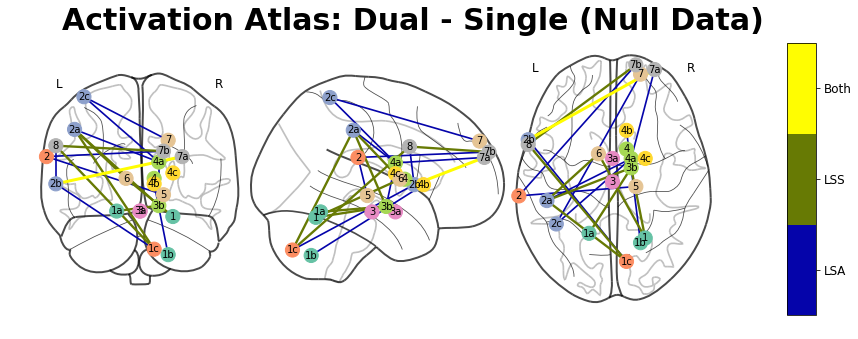

In [129]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Dual - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-dualXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.69

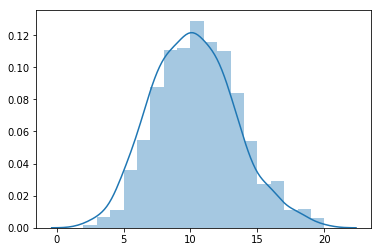

In [130]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['dual'], fb_act_lss_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [131]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.7270661413238029

In [132]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.473

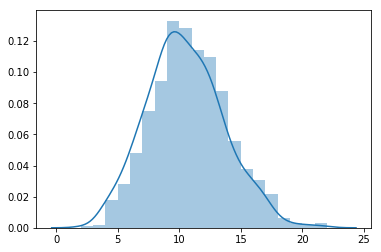

In [133]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['dual'], fb_act_lsa_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [134]:
binom_pvalue = binom_test(num_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.48084080285033914

In [135]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [136]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(1,)

In [137]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: repeat - single (task)

Number of Positives lsa: 5504 / 79800
Number of Positives lss: 5256 / 79800
Number of overlapping positives: 801 / 79800


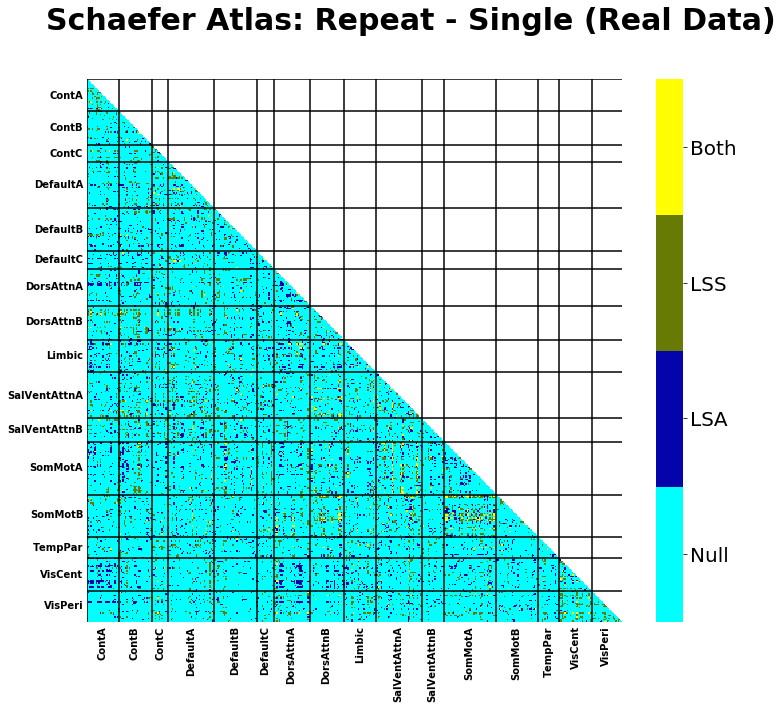

In [138]:
fig, lss_model_df1, lsa_model_df1, overlap_df1 = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['repeat'][:20],
                       ts_sch_lss_objs['single'][:20],
                       ts_sch_lsa_objs['repeat'][:20],
                       ts_sch_lsa_objs['single'][:20],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

Number of Positives lsa: 6663 / 79800
Number of Positives lss: 6268 / 79800
Number of overlapping positives: 1015 / 79800


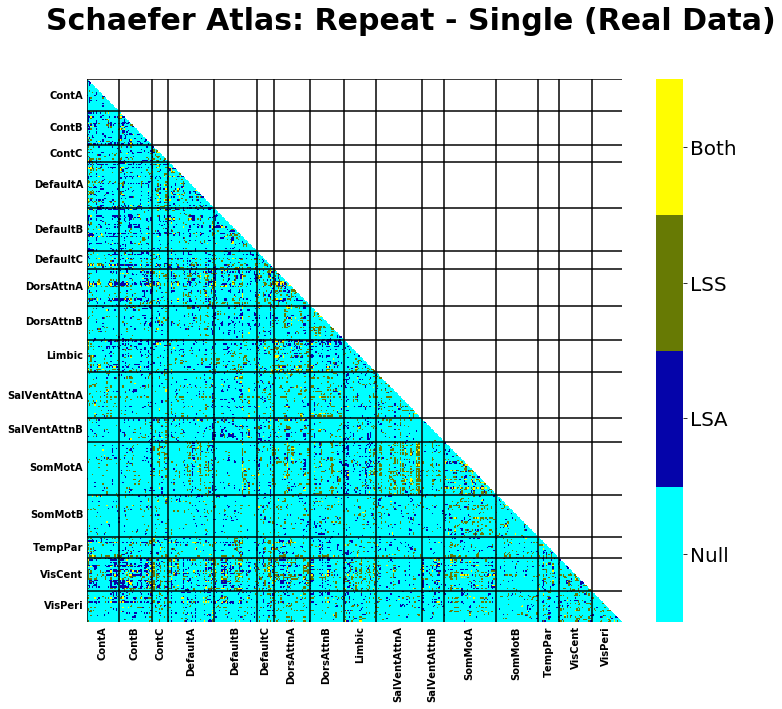

In [139]:
fig, lss_model_df2, lsa_model_df2, overlap_df2 = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['repeat'][20:],
                       ts_sch_lss_objs['single'][20:],
                       ts_sch_lsa_objs['repeat'][20:],
                       ts_sch_lsa_objs['single'][20:],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [140]:
sig1 = (lsa_model_df1['p_value'] < 0.05)
sig2 = (lsa_model_df2['p_value'] < 0.05)
dice_coef = 2 * (sig1 & sig2).sum() / (sig1.sum() + sig2.sum()) 
dice_coef

0.11243527574586998

In [141]:
sig1 = (lss_model_df1['p_value'] < 0.05)
sig2 = (lss_model_df2['p_value'] < 0.05)
dice_coef = 2 * (sig1 & sig2).sum() / (sig1.sum() + sig2.sum()) 
dice_coef

0.08625477264838598

Number of Positives lsa: 9145 / 79800
Number of Positives lss: 7631 / 79800
Number of overlapping positives: 1608 / 79800


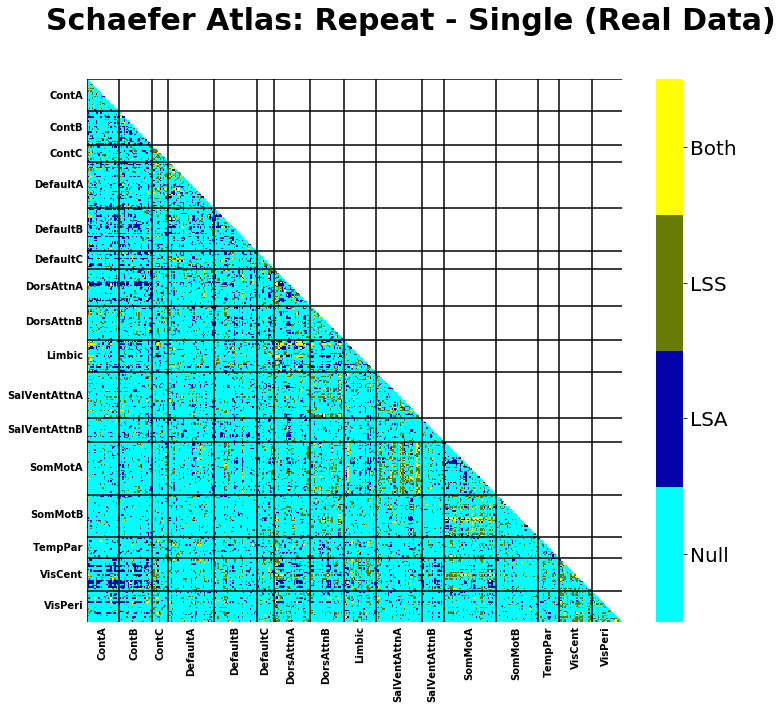

In [142]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['repeat'],
                       ts_sch_lss_objs['single'],
                       ts_sch_lsa_objs['repeat'],
                       ts_sch_lsa_objs['single'],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

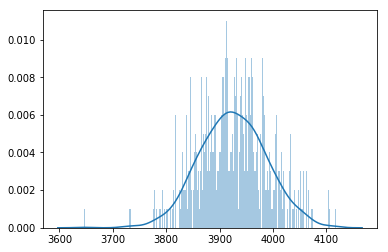

In [143]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_sch_lss_objs['repeat'], ts_sch_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [144]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.0

In [145]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

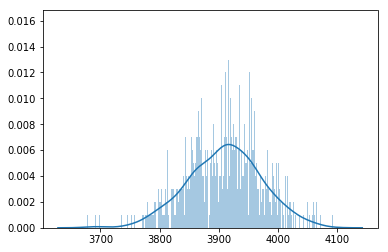

In [146]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_sch_lsa_objs['repeat'], ts_sch_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [147]:
binom_pvalue = binom_test(num_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.0

In [148]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [149]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1) // 2

21

In [150]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2) // 2

18

In [151]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3) // 2

3

0.0

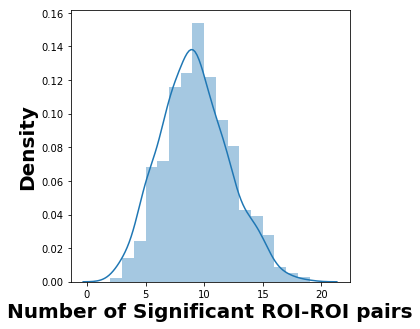

In [152]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['repeat'], 'repeat', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lss_objs['single'], 'single', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [153]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.0005989147481295893

In [154]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

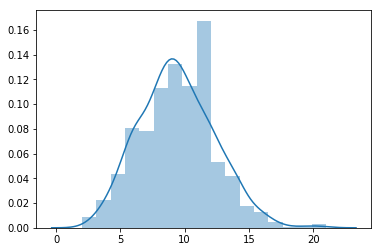

In [155]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lsa_objs['repeat'], 'repeat', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lsa_objs['single'], 'single', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)))

bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [156]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

3.146980244342121e-05

In [157]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [158]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(3,)

In [159]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: repeat - single (null)

Number of Positives lsa: 6762 / 79800
Number of Positives lss: 8461 / 79800
Number of overlapping positives: 1803 / 79800


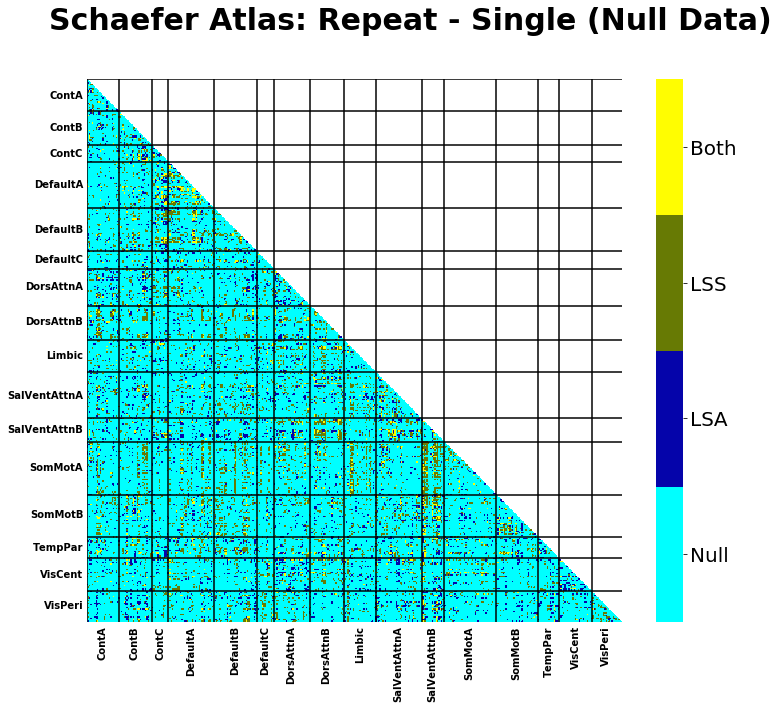

In [160]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['repeat'],
                       fb_sch_lss_objs['single'],
                       fb_sch_lsa_objs['repeat'],
                       fb_sch_lsa_objs['single'],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

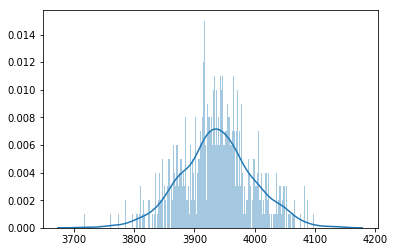

In [161]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_sch_lss_objs['repeat'], fb_sch_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [162]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.0

In [163]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

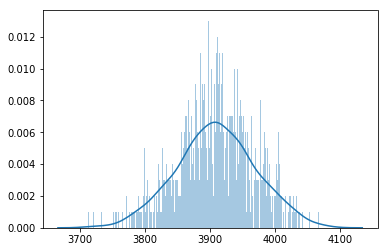

In [164]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_sch_lsa_objs['repeat'], fb_sch_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [165]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.0

In [166]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [167]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

48

In [168]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

18

In [169]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

0

0.601

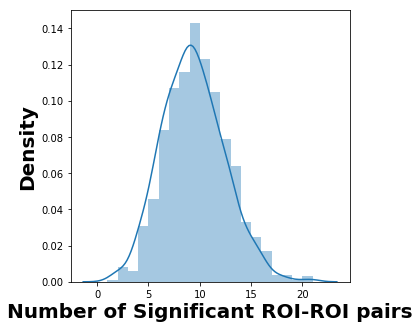

In [170]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lss_objs['repeat'], 'repeat', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lss_objs['single'], 'single', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [171]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.612935090598441

In [172]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

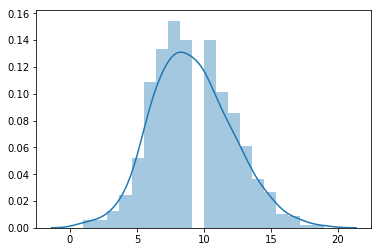

In [173]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lsa_objs['repeat'], 'repeat', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lsa_objs['single'], 'single', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)))
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [174]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

3.146980244342121e-05

In [175]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [176]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [177]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(2,)

### Activation Atlas: repeat - single (task)

Number of Positives lsa: 21 / 210
Number of Positives lss: 16 / 210
Number of overlapping positives: 3 / 210


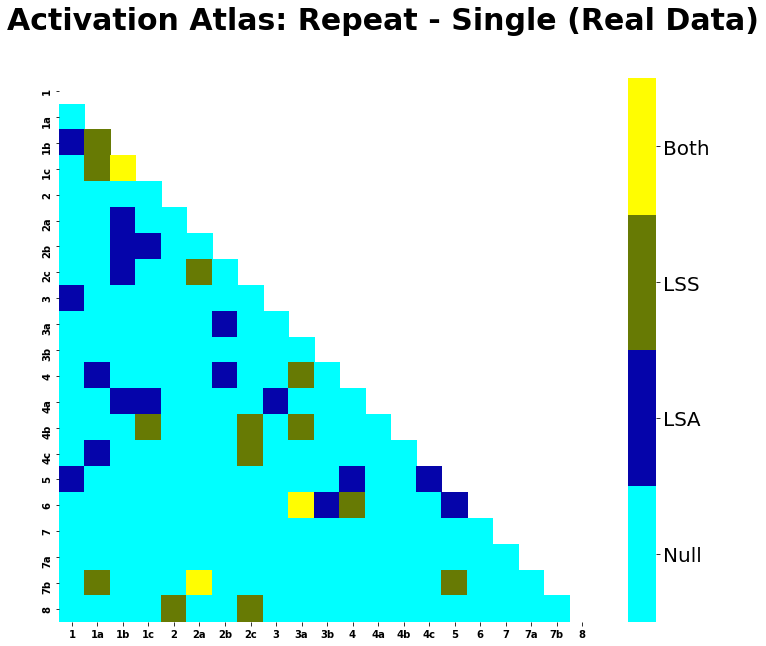

In [178]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['repeat'],
                       ts_act_lss_objs['single'],
                       ts_act_lsa_objs['repeat'],
                       ts_act_lsa_objs['single'],
                       'repeat', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-repeatXsingle'
save_eps(fig, outfile)

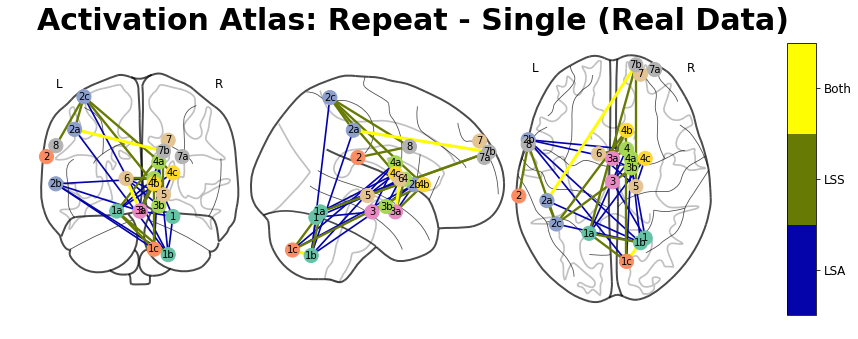

In [179]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-repeatXsingle'
save_eps(fig, outfile)

In [180]:
fig.suptitle("")
save_eps(fig, outfile + '_separate')

0.047

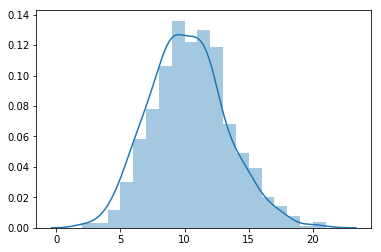

In [181]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['repeat'], ts_act_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [182]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.06332235432472427

In [183]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.005

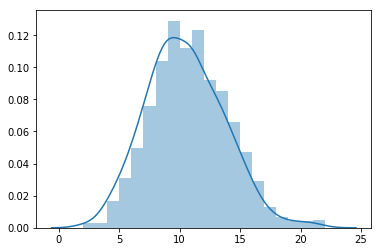

In [184]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['repeat'], ts_act_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [185]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.0021213168013582465

In [186]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [187]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [188]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: repeat - single (null)

Number of Positives lsa: 10 / 210
Number of Positives lss: 12 / 210
Number of overlapping positives: 1 / 210


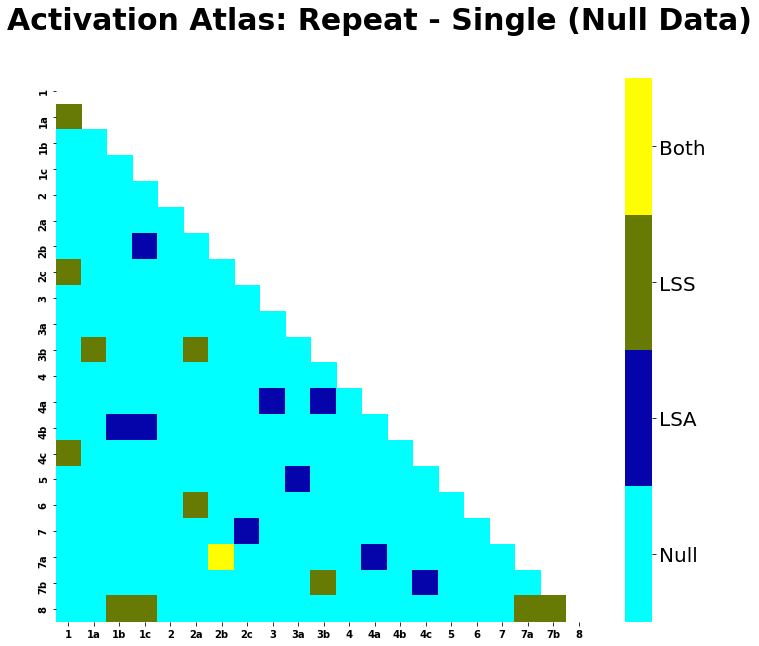

In [189]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['repeat'],
                       fb_act_lss_objs['single'],
                       fb_act_lsa_objs['repeat'],
                       fb_act_lsa_objs['single'],
                       'repeat', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

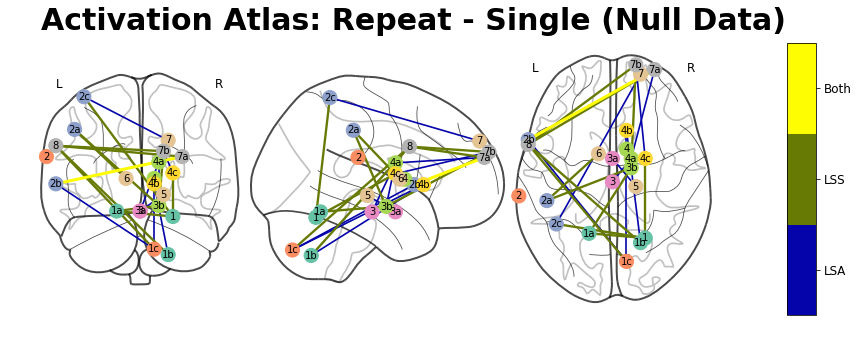

In [190]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.331

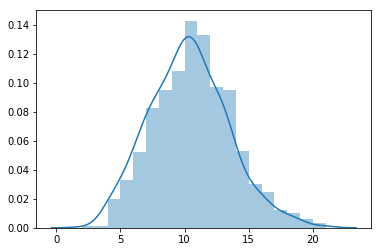

In [191]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['repeat'], fb_act_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [192]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.35971525546679667

In [193]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.58

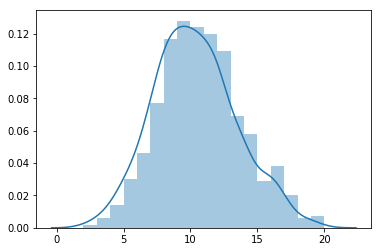

In [194]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['repeat'], fb_act_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [195]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.6074169998660277

In [196]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [197]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [198]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: switch - repeat (task)

In [201]:
ts_sch_lss_objs.keys()

dict_keys(['dual', 'repeat', 'single'])

Number of Positives lsa: 5153 / 79800
Number of Positives lss: 3462 / 79800
Number of overlapping positives: 397 / 79800


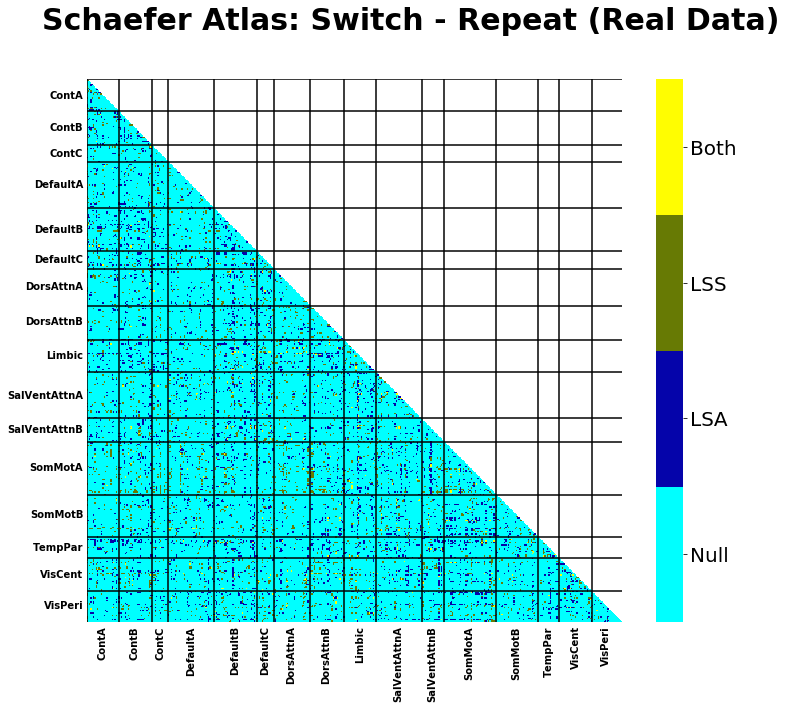

In [204]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'],
                       ts_sch_lss_objs['repeat'],
                       ts_sch_lsa_objs['switch'],
                       ts_sch_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchxrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

Number of Positives lsa: 4731 / 79800
Number of Positives lss: 3195 / 79800
Number of overlapping positives: 523 / 79800


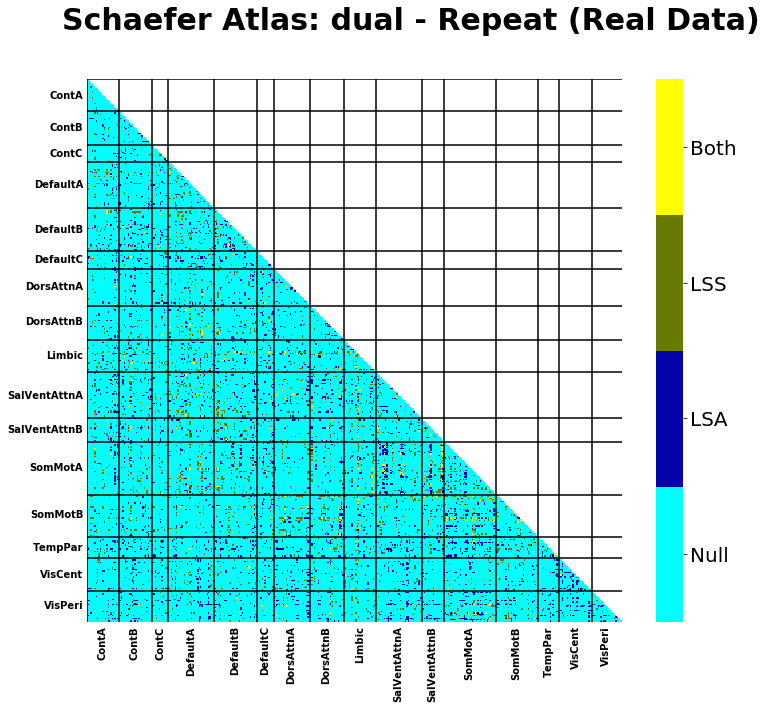

In [205]:
fig, lss_model_df1, lsa_model_df1, overlap_df1 = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'][:20],
                       ts_sch_lss_objs['repeat'][:20],
                       ts_sch_lsa_objs['switch'][:20],
                       ts_sch_lsa_objs['repeat'][:20],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchxrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

Number of Positives lsa: 3974 / 79800
Number of Positives lss: 3346 / 79800
Number of overlapping positives: 294 / 79800


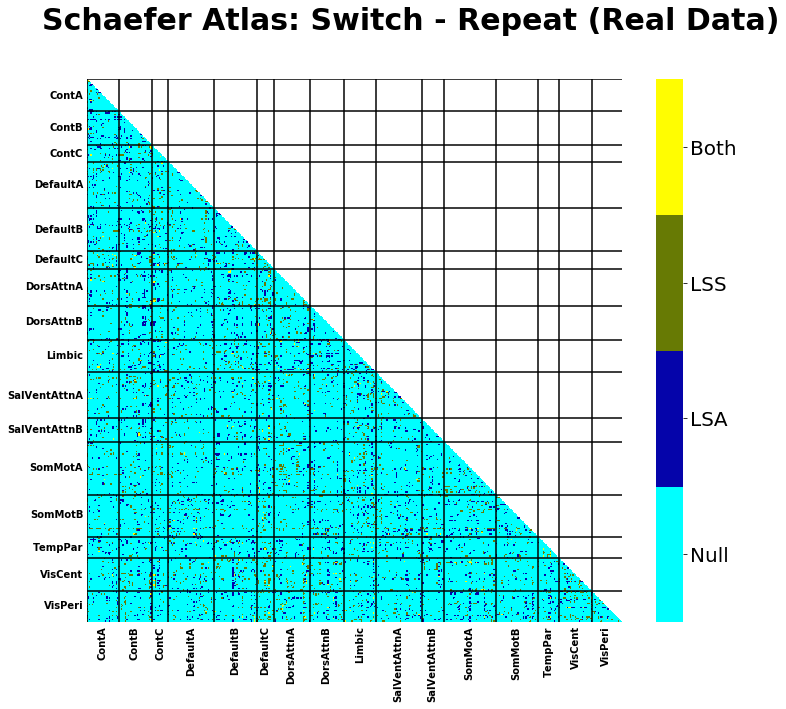

In [206]:
fig, lss_model_df2, lsa_model_df2, overlap_df2 = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'][20:],
                       ts_sch_lss_objs['repeat'][20:],
                       ts_sch_lsa_objs['switch'][20:],
                       ts_sch_lsa_objs['repeat'][20:],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchxrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [207]:
((lsa_model_df1['p_value'] < 0.05) & (lsa_model_df2['p_value'] < 0.05)).sum()

210

In [208]:
((lss_model_df1['p_value'] < 0.05) & (lss_model_df2['p_value'] < 0.05)).sum()

145

1.0

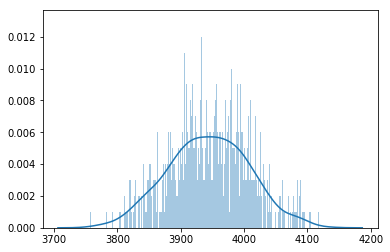

In [209]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_sch_lss_objs['switch'], ts_sch_lss_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [210]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.9999999999999999

In [211]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

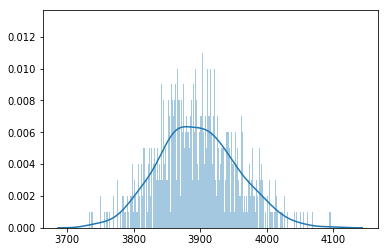

In [212]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['switch'], ts_act_lsa_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [213]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

1.3806112483211721e-73

In [214]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [215]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

16

In [216]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

16

In [217]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

0

0.698

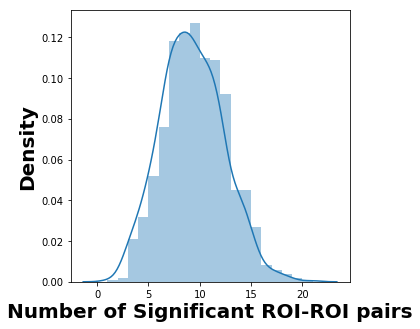

In [218]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['dual'], 'dual', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lss_objs['repeat'], 'repeat', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [219]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.7379909715999342

In [220]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.7

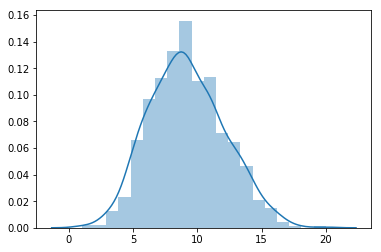

In [221]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lsa_objs['dual'], 'dual', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lsa_objs['repeat'], 'repeat', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)))
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [222]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.7379909715999342

In [223]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [224]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [225]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: switch- repeat (null)

Number of Positives lsa: 3904 / 79800
Number of Positives lss: 4443 / 79800
Number of overlapping positives: 421 / 79800


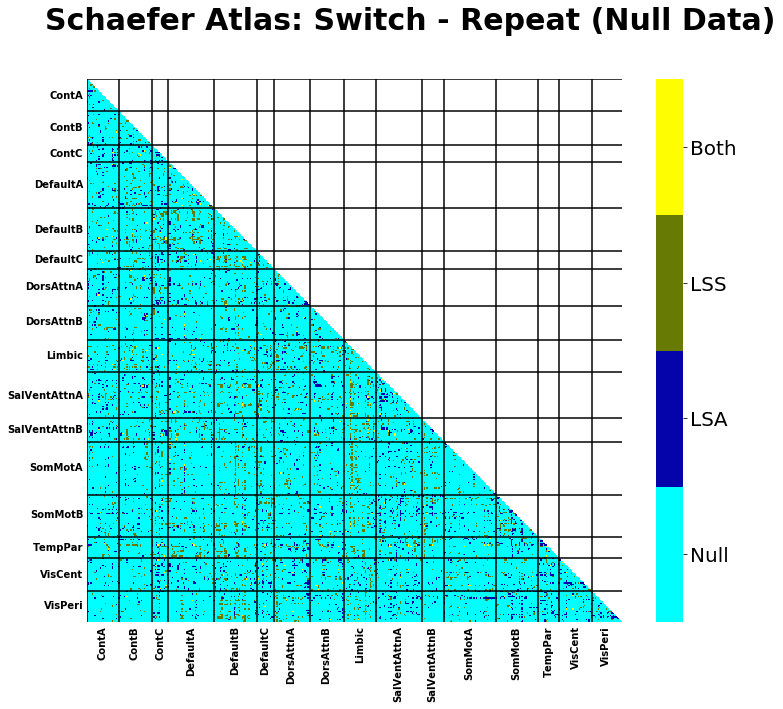

In [226]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['switch'],
                       fb_sch_lss_objs['repeat'],
                       fb_sch_lsa_objs['switch'],
                       fb_sch_lsa_objs['repeat'],
                       'dual', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-switchxrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

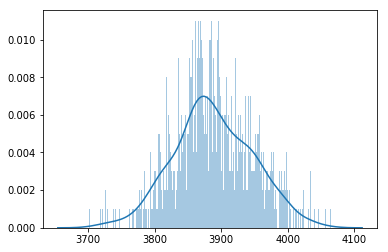

In [227]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_sch_lss_objs['switch'], fb_sch_lss_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [228]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

2.4793198871040603e-13

In [229]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.541

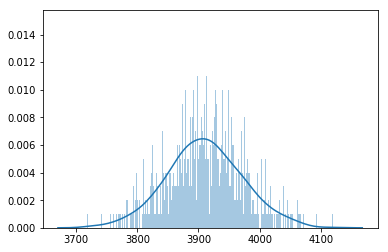

In [230]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_sch_lsa_objs['switch'], fb_sch_lsa_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [231]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.9203426478598629

In [232]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [233]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

60

In [234]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

12

In [235]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

0

In [236]:
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
np.sum(lsa_model_df['p_value'][bool_query] < 0.05)

30

0.906

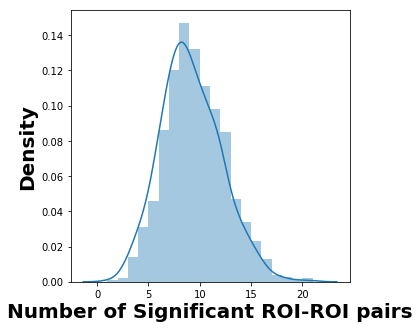

In [237]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lss_objs['dual'], 'dual', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lss_objs['repeat'], 'repeat', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [238]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.9169435901010691

In [239]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

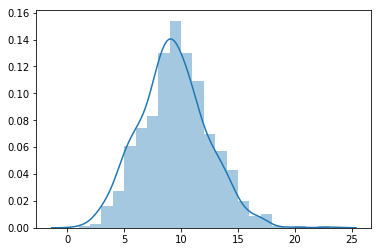

In [240]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lsa_objs['dual'], 'dual', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lsa_objs['repeat'], 'repeat', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)

bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
sns.distplot(lsa_perm, bins=(max(lsa_perm) - min(lsa_perm)))
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [241]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

2.6864700655560117e-08

In [242]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [243]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [244]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: switch - repeat (task)

Number of Positives lsa: 15 / 210
Number of Positives lss: 6 / 210
Number of overlapping positives: 1 / 210


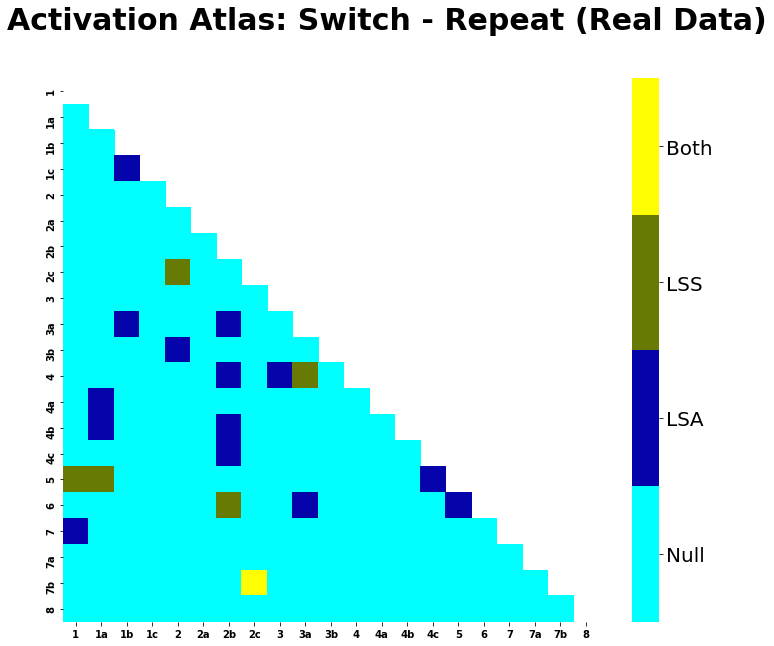

In [245]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['switch'],
                       ts_act_lss_objs['repeat'],
                       ts_act_lsa_objs['switch'],
                       ts_act_lsa_objs['repeat'],
                       'dual', 'repeat',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-switchxrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

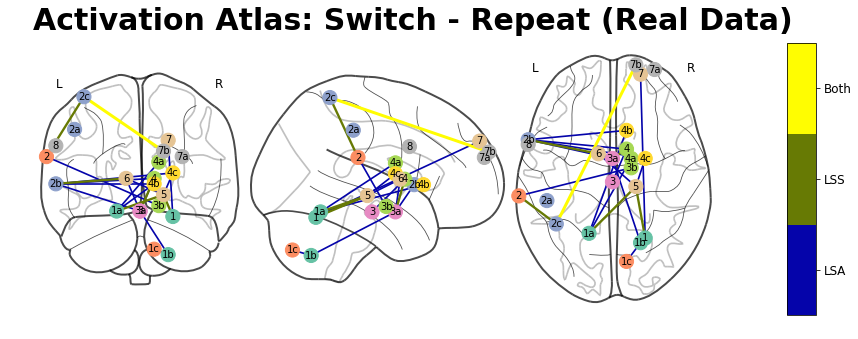

In [246]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-switchxrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.958

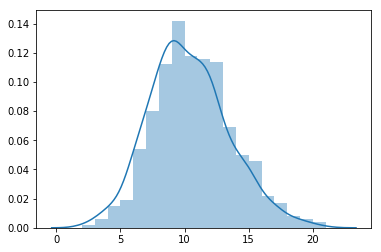

In [247]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['switch'], ts_act_lss_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [248]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.9536390167711677

In [249]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.102

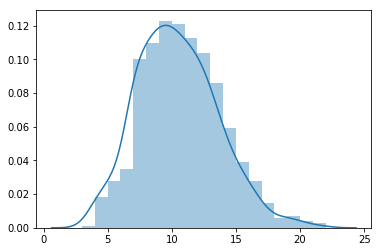

In [250]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['switch'], ts_act_lsa_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [251]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.10648599017821032

In [252]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [253]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [254]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: dual - repeat (null)

Number of Positives lsa: 12 / 210
Number of Positives lss: 3 / 210
Number of overlapping positives: 1 / 210


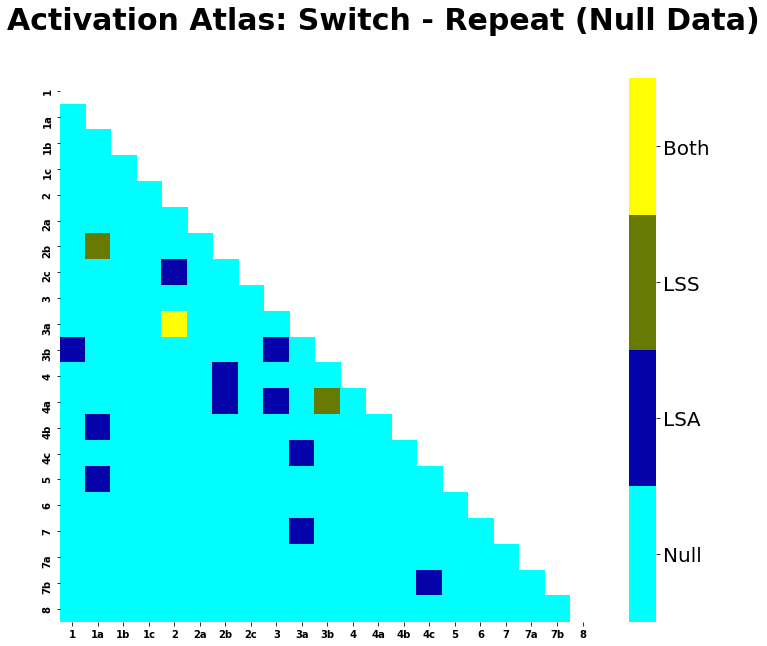

In [255]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['switch'],
                       fb_act_lss_objs['repeat'],
                       fb_act_lsa_objs['switch'],
                       fb_act_lsa_objs['repeat'],
                       'dual', 'repeat',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-switchxrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

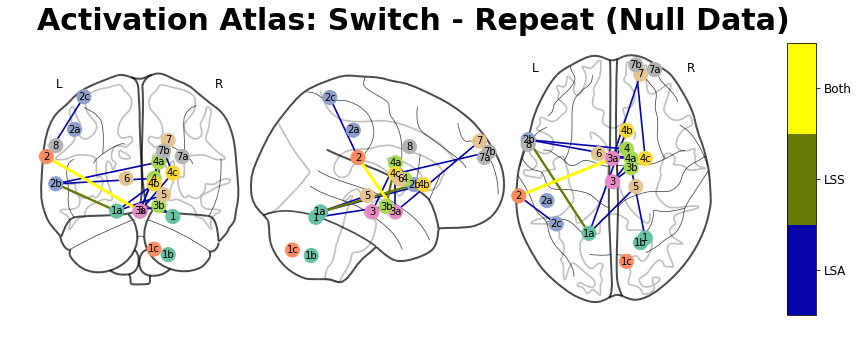

In [256]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-switchxrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.99

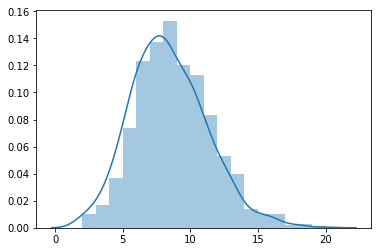

In [257]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['switch'], fb_act_lss_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [258]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.9984712389828879

In [259]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.149

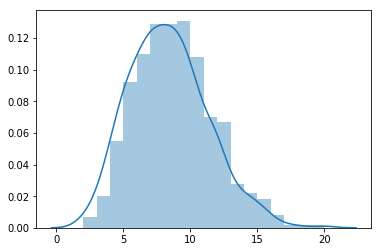

In [260]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['switch'], fb_act_lsa_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [261]:
binom_pvalue = binom_test(num_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger')
permutation_collector['binom_p_value'].append(binom_pvalue)
binom_pvalue

0.35971525546679667

In [262]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [263]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [264]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Permutation Analysis

In [265]:
permutation_df = pd.DataFrame.from_dict(permutation_collector)
permutation_df.to_csv('./outputs/permutation_results.tsv', sep='\t')

In [267]:
permutation_df

atlas  data       contrast estimator participants  \
0       schaefer  real      taskxnull       lss     filtered   
1       schaefer  real      taskxnull       lsa     filtered   
2   schaeferbest  real      taskxnull       lss     filtered   
3   schaeferbest  real      taskxnull       lsa     filtered   
4     activation  real      taskxnull       lss     filtered   
5     activation  real      taskxnull       lsa     filtered   
6       schaefer  real    dualxsingle       lss     filtered   
7       schaefer  real    dualxsingle       lsa     filtered   
8   schaeferbest  real    dualxsingle       lss     filtered   
9   schaeferbest  real    dualxsingle       lsa     filtered   
10      schaefer  null    dualxsingle       lss     filtered   
11      schaefer  null    dualxsingle       lsa     filtered   
12  schaeferbest  null    dualxsingle       lss     filtered   
13  schaeferbest  null    dualxsingle       lsa     filtered   
14    activation  real    dualxsingle       lss     filtered   
15    activation  real    dualxsingle       lsa     filtered   
16    activation  null    dualxsingle       lss     filtered   
17    activation  null    dualxsingle       lsa     filtered   
18      schaefer  real  repeatxsingle       lss     filtered   
19      schaefer  real  repeatxsingle       lsa     filtered   
20  schaeferbest  real  repeatxsingle       lss     filtered   
21  schaeferbest  real  repeatxsingle       lsa     filtered   
22      schaefer  null  repeatxsingle       lss     filtered   
23      schaefer  null  repeatxsingle       lsa     filtered   
24  schaeferbest  null  repeatxsingle       lss     filtered   
25  schaeferbest  null  repeatxsingle       lsa     filtered   
26    activation  real  repeatxsingle       lss     filtered   
27    activation  real  repeatxsingle       lsa     filtered   
28    activation  null  repeatxsingle       lss     filtered   
29    activation  null  repeatxsingle       lsa     filtered   
30      schaefer  real  switchxrepeat       lss     filtered   
31      schaefer  real  switchxrepeat       lsa     filtered   
32  schaeferbest  real  switchxrepeat       lss     filtered   
33  schaeferbest  real  switchxrepeat       lsa     filtered   
34      schaefer  null  switchxrepeat       lss     filtered   
35      schaefer  null  switchxrepeat       lsa     filtered   
36  schaeferbest  null  switchxrepeat       lss     filtered   
37  schaeferbest  null  switchxrepeat       lsa     filtered   
38    activation  real  switchxrepeat       lss     filtered   
39    activation  real  switchxrepeat       lsa     filtered   
40    activation  null  switchxrepeat       lss     filtered   
41    activation  null  switchxrepeat       lsa     filtered   

                                         permutations  observed_value  \
0   [3940, 3912, 3906, 3996, 4007, 3954, 3790, 392...           18883   
1   [3895, 3946, 4002, 3952, 3913, 3970, 3890, 400...           12129   
2   [11, 14, 14, 8, 11, 5, 14, 9, 11, 17, 11, 13, ...              28   
3   [8, 10, 13, 9, 17, 7, 12, 10, 6, 7, 10, 6, 13,...              40   
4   [13, 9, 9, 7, 15, 12, 15, 12, 10, 10, 13, 13, ...              27   
5   [11, 12, 9, 7, 5, 14, 8, 15, 13, 13, 16, 9, 13...              25   
6   [3977, 3865, 3987, 3856, 3902, 3963, 3967, 401...            7723   
7   [3998, 3876, 3915, 4026, 3994, 3954, 4071, 394...            8069   
8   [6, 7, 11, 10, 10, 7, 6, 7, 11, 11, 8, 15, 14,...              20   
9   [9, 11, 7, 12, 7, 10, 7, 10, 12, 12, 10, 12, 1...              15   
10  [3853, 4019, 3981, 4020, 3974, 3928, 3863, 377...            8213   
11  [3947, 3952, 3845, 3943, 3817, 3930, 4025, 387...            6384   
12  [9, 9, 6, 10, 12, 9, 11, 16, 5, 8, 15, 13, 9, ...               7   
13  [7, 7, 9, 10, 11, 10, 9, 9, 12, 11, 13, 6, 9, ...              17   
14  [17, 10, 10, 10, 10, 11, 14, 14, 16, 8, 11, 16...              19   
15  [10, 7, 12, 13, 8, 14, 15, 7, 9, 9, 11, 9, 10,...               9   
16  [10, 13, 12, 

In [268]:
permutation_df.query('atlas == "schaeferbest"')

atlas  data       contrast estimator participants  \
2   schaeferbest  real      taskxnull       lss     filtered   
3   schaeferbest  real      taskxnull       lsa     filtered   
8   schaeferbest  real    dualxsingle       lss     filtered   
9   schaeferbest  real    dualxsingle       lsa     filtered   
12  schaeferbest  null    dualxsingle       lss     filtered   
13  schaeferbest  null    dualxsingle       lsa     filtered   
20  schaeferbest  real  repeatxsingle       lss     filtered   
21  schaeferbest  real  repeatxsingle       lsa     filtered   
24  schaeferbest  null  repeatxsingle       lss     filtered   
25  schaeferbest  null  repeatxsingle       lsa     filtered   
32  schaeferbest  real  switchxrepeat       lss     filtered   
33  schaeferbest  real  switchxrepeat       lsa     filtered   
36  schaeferbest  null  switchxrepeat       lss     filtered   
37  schaeferbest  null  switchxrepeat       lsa     filtered   

                                         permutations  observed_value  \
2   [11, 14, 14, 8, 11, 5, 14, 9, 11, 17, 11, 13, ...              28   
3   [8, 10, 13, 9, 17, 7, 12, 10, 6, 7, 10, 6, 13,...              40   
8   [6, 7, 11, 10, 10, 7, 6, 7, 11, 11, 8, 15, 14,...              20   
9   [9, 11, 7, 12, 7, 10, 7, 10, 12, 12, 10, 12, 1...              15   
12  [9, 9, 6, 10, 12, 9, 11, 16, 5, 8, 15, 13, 9, ...               7   
13  [7, 7, 9, 10, 11, 10, 9, 9, 12, 11, 13, 6, 9, ...              17   
20  [4, 6, 12, 9, 12, 6, 9, 7, 8, 10, 5, 18, 10, 9...              21   
21  [9, 13, 8, 15, 11, 12, 8, 10, 12, 11, 8, 10, 1...              24   
24  [5, 9, 8, 10, 8, 9, 13, 7, 9, 8, 6, 10, 12, 12...               9   
25  [8, 13, 12, 9, 5, 11, 7, 7, 6, 6, 6, 10, 8, 7,...              24   
32  [12, 7, 6, 12, 3, 10, 7, 12, 6, 7, 14, 11, 8, ...               8   
33  [11, 7, 12, 12, 7, 6, 11, 8, 6, 10, 9, 8, 7, 1...               8   
36  [10, 7, 7, 7, 6, 12, 12, 9, 9, 16, 6, 6, 10, 8...               6   
37  [5, 6, 9, 10, 10, 12, 9, 13, 10, 9, 9, 11, 6, ...              30   

    p_value  binom_p_value  
2     0.000   3.332543e-07  
3     0.000   1.063779e-14  
8     0.001   1.452794e-03  
9     0.048   5.520896e-02  
12    0.845   8.418625e-01  
13    0.011   1.520590e-02  
20    0.000   5.989147e-04  
21    0.000   3.146980e-05  
24    0.601   6.129351e-01  
25    0.000   3.146980e-05  
32    0.698   7.379910e-01  
33    0.700   7.379910e-01  
36    0.906   9.169436e-01  
37    0.000   2.686470e-08

In [269]:
# https://stackoverflow.com/questions/27263805/pandas-column-of-lists-create-a-row-for-each-list-element
lst_col = 'permutations'

permutation_long_df = pd.DataFrame({
      col:np.repeat(permutation_df[col].values, permutation_df[lst_col].str.len())
      for col in permutation_df.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(permutation_df[lst_col].values)})[permutation_df.columns]
permutation_long_df.shape

(42000, 9)

In [440]:
contrast_order_real = ['taskxnull', 'dualxsingle', 'repeatxsingle', 'switchxrepeat']
contrast_order_null = contrast_order_real[1:]
method_order = ['lsa', 'lss']
def make_summary_plots(contrast_order,
                       method_order,
                       permutation_df,
                       atlas,
                       data,
                       n_roi_roi_pairs,
                       participants="filtered"):
    
    # filter down to the relevant data
    query = "(data == '{data}') & (atlas == '{atlas}') & (participants == '{participants}')".format(
        data=data, atlas=atlas, participants=participants)
    
    permutation_filt_df = permutation_df.query(query)
    
    # create a percentage
    permutation_filt_df['observed_value_percent'] = (permutation_filt_df['observed_value'] / n_roi_roi_pairs) * 100

    # make the figure
    fig, ax = plt.subplots(figsize=(8, 5))

    sns.swarmplot(x='contrast',
                  order=contrast_order,
                  y='observed_value_percent',
                  hue='estimator',
                  hue_order=['lsa', 'lss'],
                  dodge=True,
                  size=15,
                  ax=ax,
                  data=permutation_filt_df)

    ax.set_ylim(0, 25)

    # create confidence interval
    lower_confidence, higher_confidence = proportion_confint(n_roi_roi_pairs*0.05, n_roi_roi_pairs)
    ax.axhspan(lower_confidence*100, higher_confidence*100, alpha=0.15,
               facecolor='red', edgecolor=None)

    # set y label
    ax.set_ylabel("Significant ROI-ROI Pairs (%)", weight='heavy', size=15)

    # set x label
    ax.set_xlabel("")

    # set x tick marks
    new_ticks = [s.get_text().replace('x', ' - ') for s in ax.get_xticklabels()]
    ax.set_xticklabels(new_ticks, fontdict={'weight': 'heavy', 'size': 13}, rotation=35)

    # change the alpha of the legend, and make text more visible
    [p.set(alpha=alpha, facecolor=p.get_facecolor()) for p in ax.legend_.get_patches()];
    ax.legend_.set_title("")
    ax.legend_.texts[0].set(size=12, weight='bold')

    # draw false positive line
    ax.axhline(5, color='red', linestyle='--', linewidth=3)
    ax.text(ax.get_xlim()[0] + 0.01, 3.5, "Expected False Positive Rate (5%)", weight='heavy');

    # separate the dot pairs
    category_xval = (ax.get_xticks() + 0.5)[0:-1]
    for xval in category_xval:
        ax.axvline(xval, color='black')

    # change the alpha of the violins
    contrast_orders = [item for item in contrast_order for i in range(len(method_order))]
    method_orders = method_order * len(contrast_order)

    # annotate dots with p-values
    for contrast, method, point in zip(contrast_orders, method_orders, ax.collections[:len(contrast_order) * len(method_order)]):
        df_query = "(estimator == '{method}') & (contrast == '{contrast}')".format(method=method, contrast=contrast)
        p_val = permutation_filt_df.query(df_query)['binom_p_value'].unique()[0]
        # import pdb; pdb.set_trace()
        p_val_round = round(p_val, 3)

        if p_val_round == 0:
            p_str = 'p<{:.3f}'.format(p_val_round + 0.001)
        else:
            p_str = 'p={:.3f}'.format(p_val_round)

        # bold significant p-value
        if p_val < 0.05:
            weight = 'bold'
        else:
            weight = 'normal'

        coordinates = point.get_offsets()
        x_text, y = coordinates[0, 0], coordinates[0, 1]
        if y < 4.5 and y > 3.5:
            y_offset = -1.9
        else:
            y_offset = 1.4
        y_text = y + y_offset
        ax.text(x_text, y_text, p_str, ha='center', size=11, weight=weight)


    # make title
    atlas_dict = {
        "activation": "Activation Atlas",
        "schaefer": "Schaefer Atlas",
        "schaeferbest": "Schaefer (Top 20 CNR Regions)",
    }
    
    data_dict = {
        "null": "Null",
        "real": "Real",
    }
        
    fig.suptitle("{atlas}: {data} Data".format(atlas=atlas_dict[atlas],
                                               data=data_dict[data]),
                size=20,
                weight="heavy")
    return fig

## Activation Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


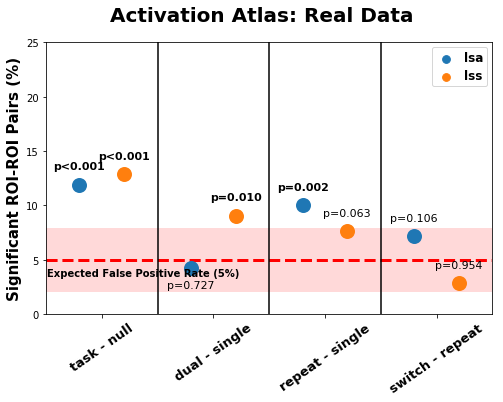

In [447]:
fig = make_summary_plots(contrast_order_real, method_order, permutation_df, "activation", "real", 210)
save_eps(fig, 'data-real_atlas-activation_participants-filtered_permutation_summary')

## Activation Atlas Null Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


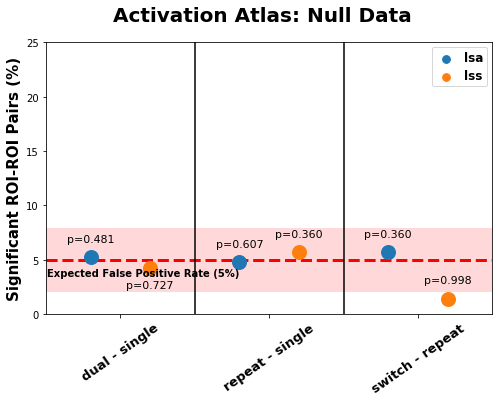

In [448]:
fig = make_summary_plots(contrast_order_null, method_order, permutation_df, "activation", "null", 210)
save_eps(fig, 'data-null_atlas-activation_participants-filtered_permutation_summary')

## Schaefer Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


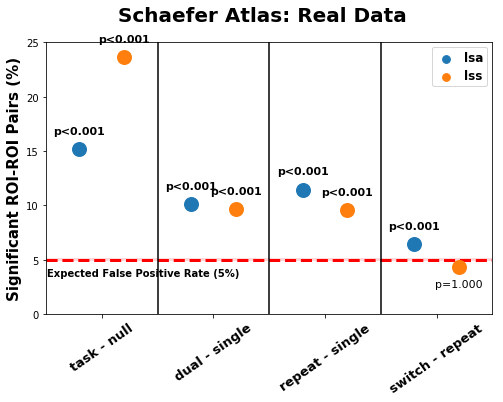

In [449]:
fig = make_summary_plots(contrast_order_real, method_order, permutation_df, "schaefer", "real", 79800)
save_eps(fig, 'data-real_atlas-schaefer_participants-filtered_permutation_summary')

## Schaefer Atlas Null Data

In [ ]:
fig = make_summary_plots(contrast_order_null, method_order, permutation_df, "schaefer", "null", 79800)
save_eps(fig, 'data-null_atlas-schaefer_participants-filtered_permutation_summary')

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Schaefer Atlas (Top 20 Parcels) Real Data

In [ ]:
fig = make_summary_plots(contrast_order_real, method_order, permutation_df, "schaeferbest", "real", 190)
save_eps(fig, 'data-real_atlas-schaeferbest_participants-filtered_permutation_summary')

## Schaefer Atlas (Top 20 Parcels) Null Data

In [ ]:
fig = make_summary_plots(contrast_order_null, method_order, permutation_df, "schaeferbest", "null", 190)
save_eps(fig, 'data-null_atlas-schaeferbest_participants-filtered_permutation_summary')

## Binomial Distribution Analysis

In [288]:
q_atlas = '(atlas == "{}")'
q_contrast = '(contrast == "{}")'
q_estimator = '(estimator == "{}")'
q_participants = '(participants == "{}")'
q_data = '(data == "{}")'

atlas_roi_roi_totals = {'schaefer': 79800, 'schaeferbest': 190, 'activation': 210}

In [289]:
# compare real/null
# positive means real data has a larger number of findings, negative means null has a larger number of findings
for atlas in permutation_df['atlas'].unique():
    for contrast in ['dualxsingle', 'repeatxsingle', 'switchxrepeat']:
        for estimator in permutation_df['estimator'].unique():
            query_real = []
            query_real.append(q_participants.format("filtered"))
            query_real.append(q_atlas.format(atlas))
            query_real.append(q_contrast.format(contrast))
            query_real.append(q_estimator.format(estimator))
            query_null = query_real.copy()
            query_real.append(q_data.format("real"))
            query_null.append(q_data.format("null"))
            query_real_str = '&'.join(query_real)
            query_null_str = '&'.join(query_null)
            positives = permutation_df.query(query_real_str)["observed_value"].unique()
            false_positives = permutation_df.query(query_null_str)["observed_value"].unique()
            positives = positives[0] if len(positives) == 1 else ValueError("Too Many Values") 
            false_positives = false_positives[0] if len(false_positives) == 1 else ValueError("Too Many Values")
            nobs = atlas_roi_roi_totals[atlas]
            chi2, p_value, _ = proportions_chisquare([positives, false_positives], nobs)
            
            # calculate cohen's h
            p1 = positives / nobs
            p2 = false_positives / nobs
            
            psi_1 = 2*np.arcsin(p1)
            psi_2 = 2*np.arcsin(p2)
            
            cohen_h = psi_1 - psi_2
            print(atlas, contrast, estimator, ":", cohen_h)

schaefer dualxsingle lss : -0.012342402505855832
schaefer dualxsingle lsa : 0.04240562268891185
schaefer repeatxsingle lss : -0.02090865386327148
schaefer repeatxsingle lsa : 0.060025501476993925
schaefer switchxrepeat lss : -0.024616836412561835
schaefer switchxrepeat lsa : 0.03135410811190102
schaeferbest dualxsingle lss : 0.13721616098598238
schaeferbest dualxsingle lsa : -0.02112777774648522
schaeferbest repeatxsingle lss : 0.12673288361222423
schaeferbest repeatxsingle lsa : 0.0
schaeferbest switchxrepeat lss : 0.021067031730019517
schaeferbest switchxrepeat lsa : -0.23288113293808443
activation dualxsingle lss : 0.0954596259193822
activation dualxsingle lsa : -0.019069324510172778
activation repeatxsingle lss : 0.038180764957890495
activation repeatxsingle lsa : 0.10506071707431335
activation switchxrepeat lss : 0.028578234060599016
activation switchxrepeat lsa : 0.028630897609715045


In [282]:
# compare lss/lsa (lss - lsa)
# positive means lss has a higher proportion, negative means lsa has a higher proportion
for atlas in permutation_df['atlas'].unique():
    for contrast in ['dualxsingle', 'repeatxsingle', 'switchxrepeat']:
        for data in permutation_df['data'].unique():
            query_lss = []
            query_lss.append(q_participants.format("filtered"))
            query_lss.append(q_atlas.format(atlas))
            query_lss.append(q_contrast.format(contrast))
            query_lss.append(q_data.format(data))
            query_lsa = query_lss.copy()
            query_lss.append(q_estimator.format("lss"))
            query_lsa.append(q_estimator.format("lsa"))
            query_lss_str = '&'.join(query_lss)
            query_lsa_str = '&'.join(query_lsa)
            positives = permutation_df.query(query_lss_str)["observed_value"].unique()
            false_positives = permutation_df.query(query_lsa_str)["observed_value"].unique()
            positives = positives[0] if len(positives) == 1 else ValueError("Too Many Values") 
            false_positives = false_positives[0] if len(false_positives) == 1 else ValueError("Too Many Values")
            nobs = atlas_roi_roi_totals[atlas]
            chi2, p_value, _ = proportions_chisquare([positives, false_positives], nobs)
            
            # calculate cohen's h
            p1 = positives / nobs
            p2 = false_positives / nobs
            
            psi_1 = 2*np.arcsin(p1)
            psi_2 = 2*np.arcsin(p2)
            
            cohen_h = psi_1 - psi_2
            print(atlas, contrast, data, ":", cohen_h)

schaefer switchxsingle real : 0.006588270557202208
schaefer switchxsingle null : 0.012328626913533272
schaefer repeatxsingle real : -0.03815683405556772
schaefer repeatxsingle null : 0.04277732128469769
schaefer switchxrepeat real : -0.04244363376105359
schaefer switchxrepeat null : 0.013527310763409267
schaeferbest switchxsingle real : -0.09498595245791593
schaeferbest switchxsingle null : -0.052713672175122586
schaeferbest repeatxsingle real : -0.031803077561833676
schaeferbest repeatxsingle null : -0.15853596117405788
schaeferbest switchxrepeat real : 0.0
schaeferbest switchxrepeat null : -0.25394816466810394
activation switchxsingle real : -0.009535745753840169
activation switchxsingle null : 0.009540735461284519
activation repeatxsingle real : -0.04780607520390309
activation repeatxsingle null : 0.019073876912519758
activation switchxrepeat real : -0.08582826523245575
activation switchxrepeat null : -0.08577560168333973


## !!! Same analysis with all participants (not just the "good" ones) !!!

In [283]:
# fb=fauxbold, ts=taskswitch
# act=activation, sch=schaefer
# lss=least squares separate, lsa=least squares all
fb_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold")

fb_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold")

ts_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch")

ts_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch")

fb_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold")

fb_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold")

ts_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch")

ts_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch")

###  Schaefer Atlas: task - null

Number of Positives lsa: 8145 / 79800
Number of Positives lss: 15119 / 79800
Number of overlapping positives: 3550 / 79800


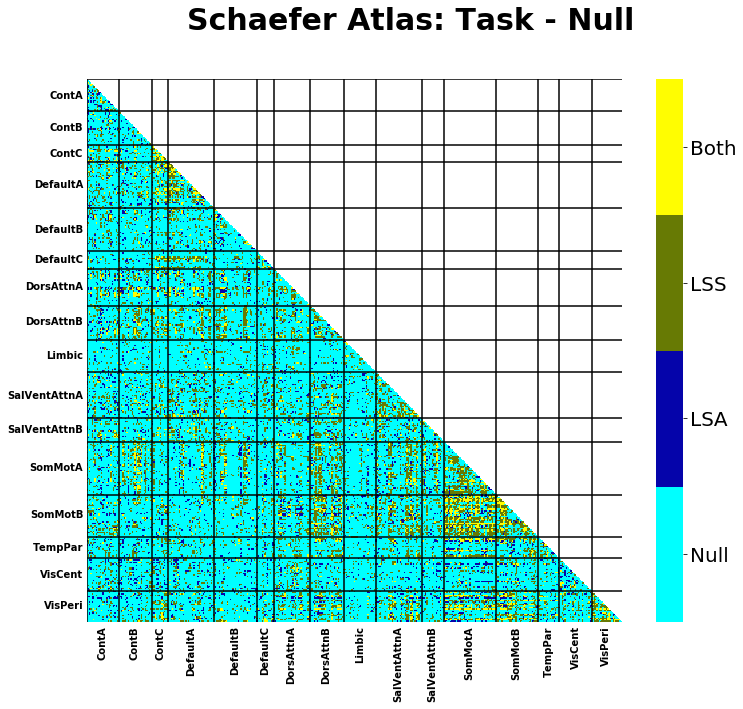

In [284]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['dual'],
                       fb_sch_lss_objs['dual'],
                       ts_sch_lsa_objs['dual'],
                       fb_sch_lsa_objs['dual'],
                       'task', 'null',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_atlas-schaefer_contrast-taskXnull_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [285]:
# LSA
np.sum(overlap_df.loc[best_regions,:].values == 1)

452

In [286]:
# LSS
np.sum(overlap_df.loc[best_regions,:].values == 2)

664

In [287]:
# Overlap
np.sum(overlap_df.loc[best_regions, :].values == 3)

130

### Test significance of pairs of correlations

In [288]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(3385,)

In [289]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(54,)

###  Activation Atlas: task - null

Number of Positives lsa: 20 / 210
Number of Positives lss: 21 / 210
Number of overlapping positives: 3 / 210


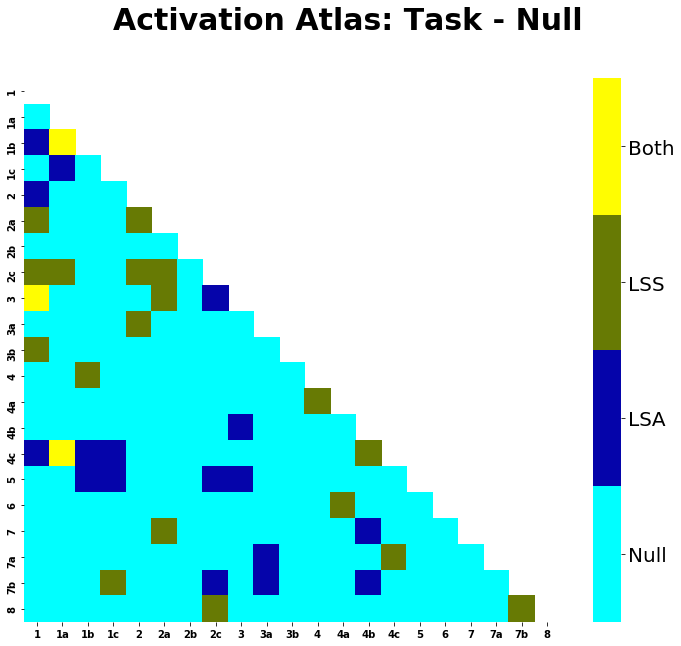

In [290]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['dual'],
                       fb_act_lss_objs['dual'],
                       ts_act_lsa_objs['dual'],
                       fb_act_lsa_objs['dual'],
                       'task', 'null',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_atlas-activation_contrast-taskXnull.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

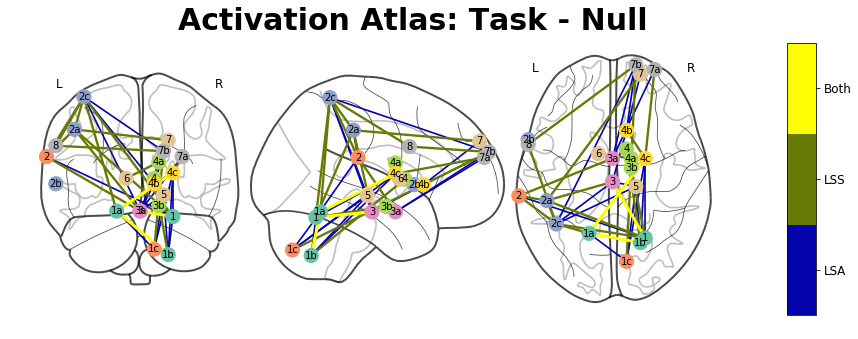

In [291]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_type-brain_atlas-activation_contrast-taskXnull_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.001

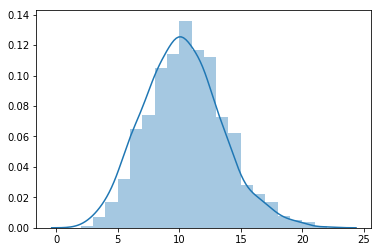

In [292]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-taskxnull_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['dual'], fb_act_lss_objs['dual'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [293]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.003

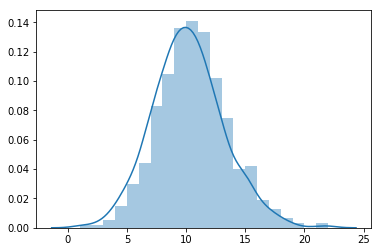

In [294]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-taskxnull_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['dual'], fb_act_lsa_objs['dual'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [295]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [296]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_model_df[lss_sig_array])
display(lss_fdr_pvalues[lss_sig_array])

estimate source_target   p_value source target
118  4.229215         1__2a  0.000081      1     2a

array([0.01707835])

In [297]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
lsa_model_df[lsa_sig_array]

Empty DataFrame
Columns: [estimate, source_target, p_value, source, target]
Index: []

LSS has one result that survives FDR correction whereas LSA has no results that survive 

### Schaefer Atlas: dual - single (task)

Number of Positives lsa: 4986 / 79800
Number of Positives lss: 7512 / 79800
Number of overlapping positives: 739 / 79800


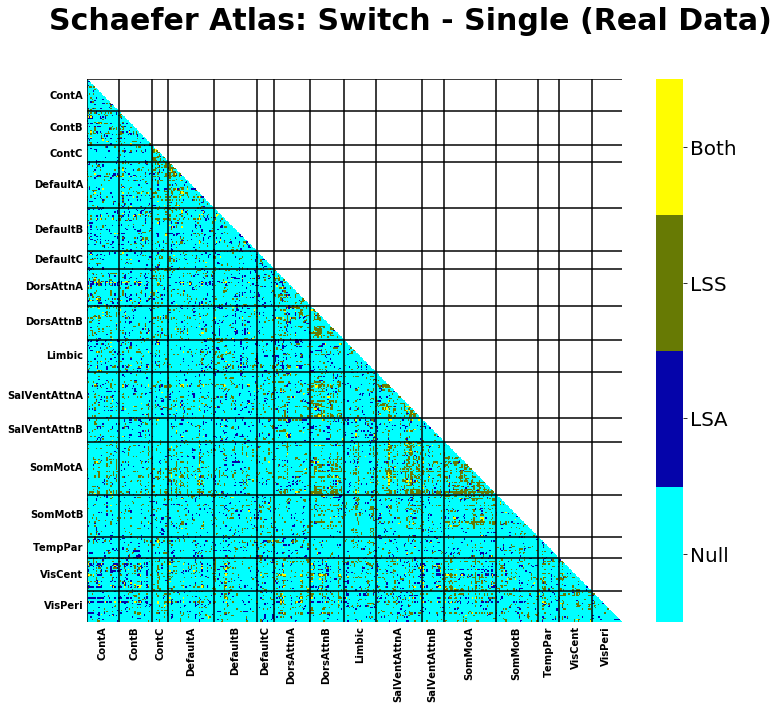

In [298]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['dual'],
                       ts_sch_lss_objs['single'],
                       ts_sch_lsa_objs['dual'],
                       ts_sch_lsa_objs['single'],
                       'dual', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: dual - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-dualXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [299]:
# LSA
np.sum(overlap_df.loc[best_regions,:].values == 1)

551

In [300]:
# LSS
np.sum(overlap_df.loc[best_regions,:].values == 2)

619

In [301]:
# Overlap
np.sum(overlap_df.loc[best_regions, :].values == 3)

104

### Test significance of pairs of correlations

In [302]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(2,)

In [303]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(1,)

### Schaefer Atlas: dual - single (null)

Number of Positives lsa: 3504 / 79800
Number of Positives lss: 5800 / 79800
Number of overlapping positives: 450 / 79800


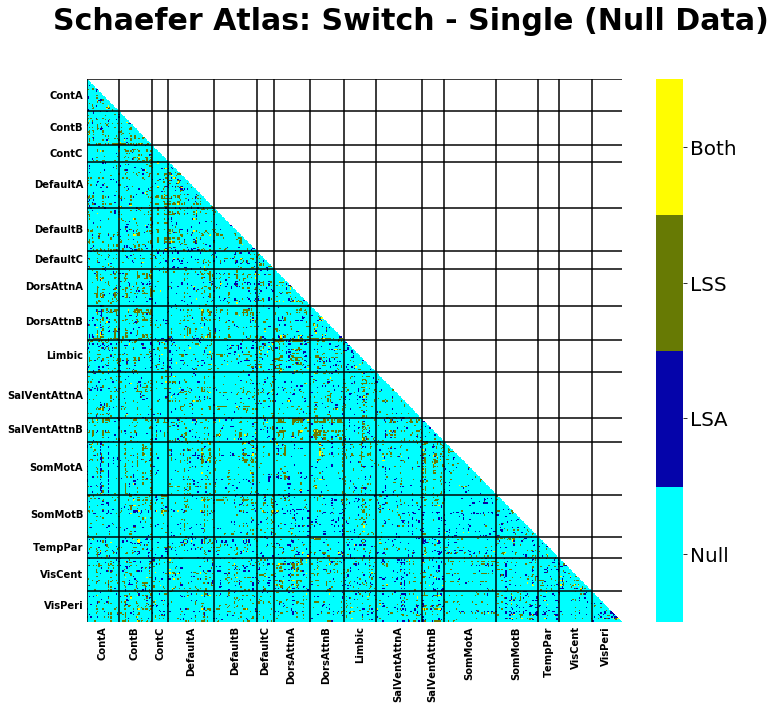

In [304]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['dual'],
                       fb_sch_lss_objs['single'],
                       fb_sch_lsa_objs['dual'],
                       fb_sch_lsa_objs['single'],
                       'dual', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: dual - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-dualXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [305]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

14

In [306]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

14

In [307]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

0

### Test significance of pairs of correlations

In [308]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [309]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: dual - single (task)

Number of Positives lsa: 10 / 210
Number of Positives lss: 15 / 210
Number of overlapping positives: 1 / 210


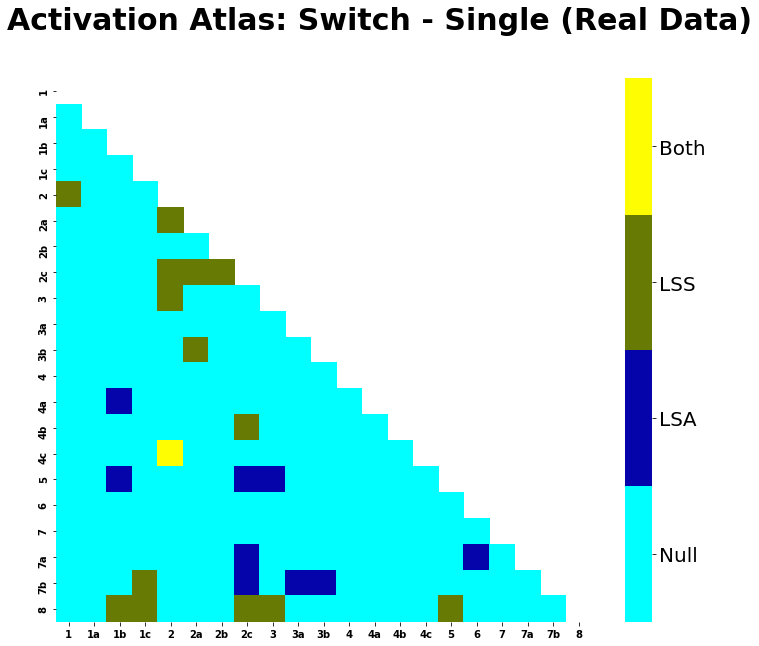

In [310]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['dual'],
                       ts_act_lss_objs['single'],
                       ts_act_lsa_objs['dual'],
                       ts_act_lsa_objs['single'],
                       'dual', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: dual - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-dualXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

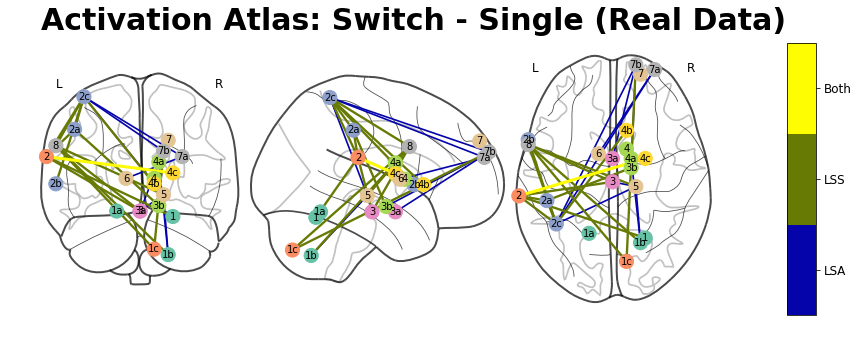

In [311]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: dual - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-dualXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.101

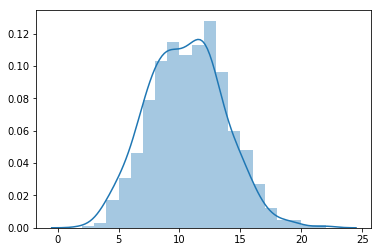

In [312]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['dual'], ts_act_lss_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [313]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.566

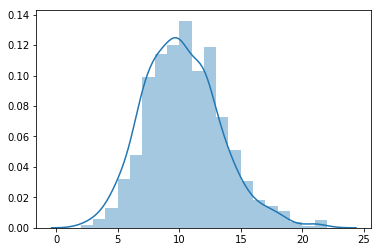

In [314]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['dual'], ts_act_lsa_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [315]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [316]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [317]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: dual - single (null)

Number of Positives lsa: 13 / 210
Number of Positives lss: 10 / 210
Number of overlapping positives: 0 / 210


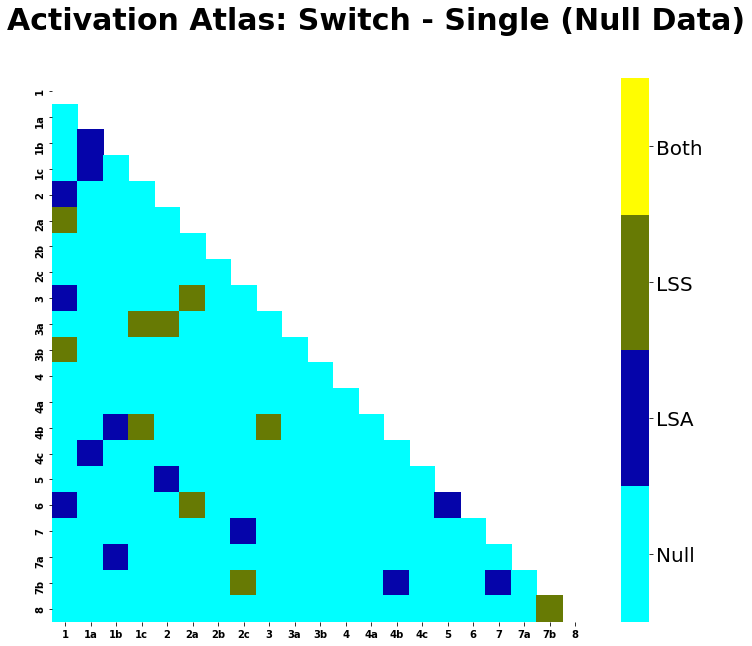

In [318]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['dual'],
                       fb_act_lss_objs['single'],
                       fb_act_lsa_objs['dual'],
                       fb_act_lsa_objs['single'],
                       'dual', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: dual - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-dualXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

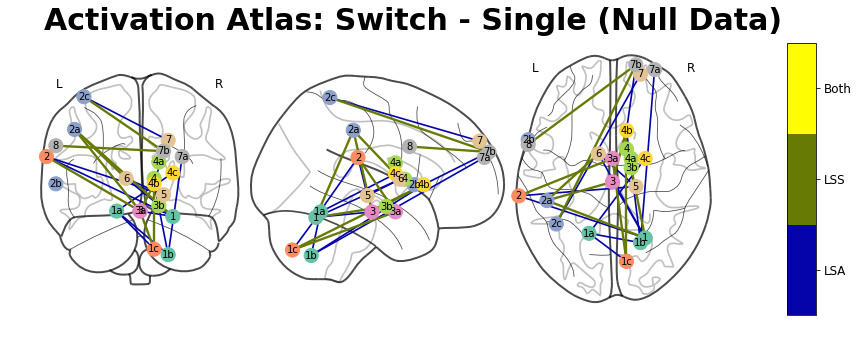

In [319]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: dual - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-dualXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.603

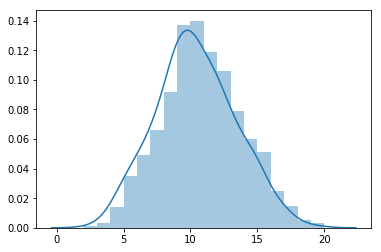

In [320]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['dual'], fb_act_lss_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [321]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.27

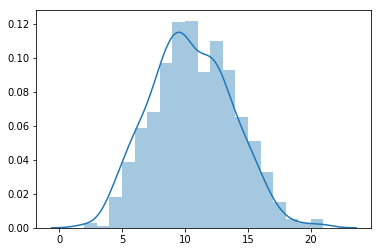

In [322]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['dual'], fb_act_lsa_objs['single'],
        'dual', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [323]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('dualxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [324]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [325]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: repeat - single (task)

Number of Positives lsa: 6018 / 79800
Number of Positives lss: 7199 / 79800
Number of overlapping positives: 691 / 79800


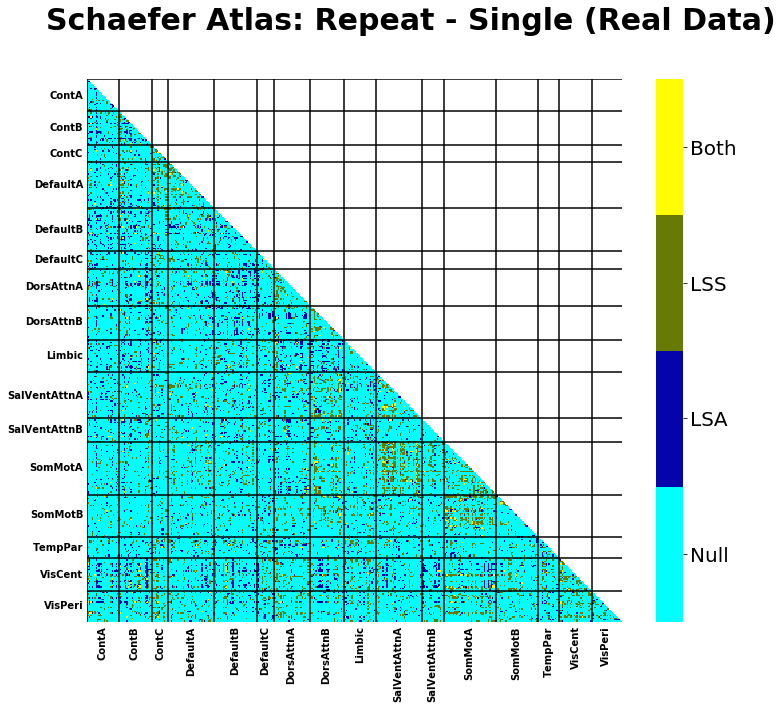

In [326]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['repeat'],
                       ts_sch_lss_objs['single'],
                       ts_sch_lsa_objs['repeat'],
                       ts_sch_lsa_objs['single'],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [327]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

42

In [328]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

30

In [329]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

4

### Test significance of pairs of correlations

In [330]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(1,)

In [331]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(1,)

In [332]:
# test if FDR correction works for the 50 best regions
query = (lsa_model_df['source'].isin(best_regions_orig)) & (lsa_model_df['target'].isin(best_regions_orig))
lsa_sig_array2, lsa_fdr_pvalues2, _, _ = multipletests(lsa_model_df[query]['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues2[lsa_sig_array2].shape)

(0,)

In [333]:
lsa_model_df

estimate                                  source_target   p_value  \
0      1.014712                  LH-ContB-Temp_2__LH-TempPar-2  0.314318   
1      0.187117            LH-ContC-pCun_1__RH-DefaultB-PFCd_1  0.852200   
2      0.103208          LH-VisCent-ExStr_7__LH-DefaultA-IPL_1  0.918142   
3     -2.357315            LH-DorsAttnA-SPL_7__LH-Limbic-OFC_2  0.021687   
4     -1.891179      LH-DefaultB-PFCv_1__RH-VisPeri-ExStrSup_9  0.063431   
5     -1.509018         RH-SomMotB-S2_3__RH-SalVentAttnA-Ins_3  0.136542   
6     -0.604976    LH-SalVentAttnB-PFCmp_1__RH-VisCent-ExStr_8  0.547476   
7     -3.095891             LH-SomMotA-6__LH-Limbic-TempPole_4  0.003085   
8     -0.152641            RH-VisPeri-ExStrSup_2__RH-SomMotA-6  0.879194   
9      0.339528           RH-SalVentAttnB-PFCl_4__RH-TempPar-7  0.735397   
10    -2.200110         LH-VisCent-ExStr_9__LH-DefaultB-Temp_5  0.031661   
11    -0.646801     LH-DefaultC-Rsp_1__RH-SalVentAttnB-PFCmp_2  0.520227   
12    -1.151215     RH-VisCent-ExStr_5__RH-SalVentAttnB-PFCv_2  0.254211   
13    -1.723266       LH-DorsAttnB-PostC_3__RH-VisCent-ExStr_4  0.089991   
14     0.137770      RH-SalVentAttnA-Ins_1__RH-DefaultA-PFCm_4  0.890884   
15    -0.011990   LH-SalVentAttnA-ParMed_3__RH-DefaultA-PFCd_1  0.990474   
16     0.142947         LH-VisPeri-ExStrSup_8__RH-ContA-PFCl_2  0.886811   
17    -0.847559     LH-SalVentAttnA-ParMed_1__LH-ContB-PFClv_1  0.400052   
18     0.577056                LH-SomMotB-Aud_4__RH-TempPar-10  0.566060   
19    -1.576924          LH-SomMotA-10__LH-DorsAttnA-TempOcc_3  0.120071   
20     0.054058                LH-ContA-IPS_4__RH-SomMotB-S2_5  0.957068   
21    -1.375095           LH-DefaultA-PCC_5__LH-DefaultB-IPL_2  0.174215   
22    -0.230182     RH-VisCent-ExStr_1__RH-DorsAttnA-TempOcc_1  0.818733   
23    -0.626685               RH-SomMotA-15__RH-DefaultC-Rsp_2  0.533243   
24    -0.981671          LH-DefaultA-PCC_2__RH-DefaultA-PFCm_3  0.330204   
25    -0.049272             LH-SomMotB-Aud_16__RH-Limbic-OFC_1  0.960866   
26    -2.614662  LH-SalVentAttnA-ParOper_3__LH-DefaultB-PFCd_6  0.011278   
27    -1.835755     LH-SomMotB-Aud_5__RH-SalVentAttnA-ParMed_6  0.071351   
28    -1.494704           RH-Limbic-TempPole_3__RH-ContB-IPL_3  0.140233   
29    -0.124401               LH-DefaultB-PFCv_2__RH-SomMotA-3  0.901413   
...         ...                                            ...       ...   
79770  0.367524         LH-DefaultA-PFCm_3__RH-DefaultB-PFCd_3  0.714521   
79771 -0.296561          LH-DorsAttnB-PostC_8__LH-ContA-Temp_1  0.767826   
79772 -1.417441            RH-SomMotA-8__RH-DefaultB-AntTemp_1  0.161526   
79773  0.045482         LH-DefaultB-PFCl_2__RH-DefaultA-PFCm_4  0.963874   
79774  0.604588               RH-DefaultA-PFCm_6__RH-TempPar-1  0.547732   
79775  0.061955                     LH-TempPar-3__RH-SomMotA-5  0.950804   
79776 -0.596833                LH-Limbic-OFC_4__LH-ContA-IPS_2  0.552864   
79777  0.741237          RH-DorsAttnB-PostC_4__RH-ContA-PFCl_5  0.461441   
79778 -0.275859           LH-VisPeri-ExStrSup_11__LH-SomMotA-8  0.783604   
79779  0.558856             LH-SomMotB-Aud_2__RH-ContB-PFCmp_1  0.578340   
79780  0.475864                     LH-SomMotA-1__RH-TempPar-5  0.635899   
79781 -0.571505            RH-SomMotA-13__RH-Limbic-TempPole_2  0.569945   
79782 -1.374066               RH-ContA-PFCl_3__RH-ContB-Temp_1  0.174533   
79783 -0.476322       LH-DefaultB-PFCd_5__RH-DorsAttnB-PostC_8  0.635575   
79784 -1.625967             RH-ContB-IPL_2__RH-DefaultB-PFCd_5  0.109198   
79785  0.050442             LH-SomMotB-Aud_6__LH-SomMotB-Aud_9  0.959937   
79786 -0.634856              LH-SomMotA-10__LH-DorsAttnA-SPL_7  0.527936   
79787 -2.408064     LH-DorsAttnA-TempOcc_2__LH-DefaultA-PFCm_6  0.019128   
79788 -0.832607       RH-VisCent-ExStr_5__RH-DorsAttnB-PostC_4  0.408368   
79789 -3.174452                 RH-SomMotA-17__RH-ContA-PFCl_1  0.002369   
79790  0.207683          LH-DefaultA-PCC_5__RH-DorsAttn

### Schaefer Atlas: repeat - single (null)

Number of Positives lsa: 5585 / 79800
Number of Positives lss: 7760 / 79800
Number of overlapping positives: 1124 / 79800


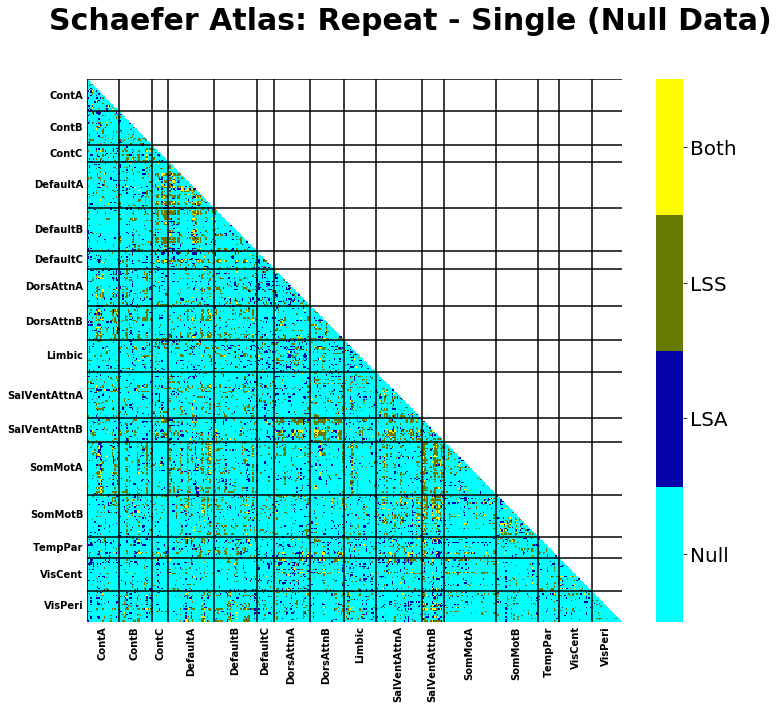

In [334]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['repeat'],
                       fb_sch_lss_objs['single'],
                       fb_sch_lsa_objs['repeat'],
                       fb_sch_lsa_objs['single'],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [335]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

24

In [336]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

12

In [337]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

0

### Test significance of pairs of correlations

In [338]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(1,)

In [339]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: repeat - single (task)

Number of Positives lsa: 17 / 210
Number of Positives lss: 17 / 210
Number of overlapping positives: 2 / 210


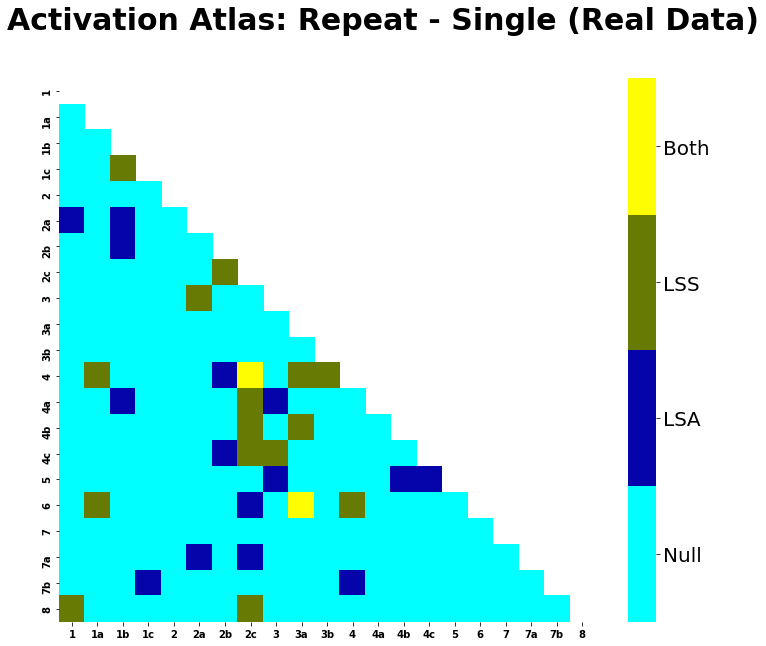

In [340]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['repeat'],
                       ts_act_lss_objs['single'],
                       ts_act_lsa_objs['repeat'],
                       ts_act_lsa_objs['single'],
                       'repeat', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

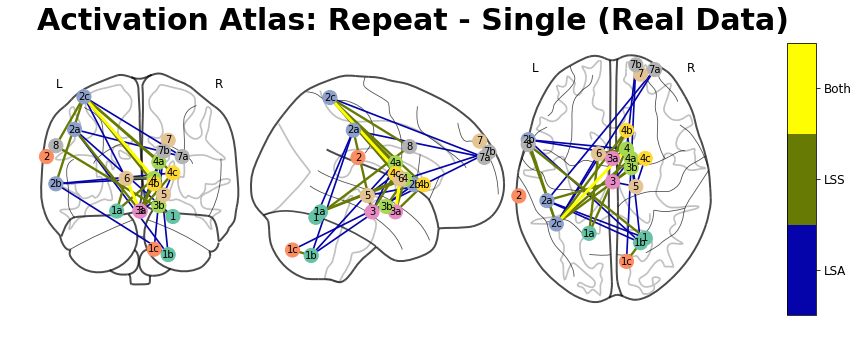

In [341]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.033

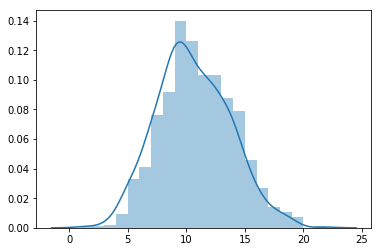

In [342]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['repeat'], ts_act_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [343]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.029

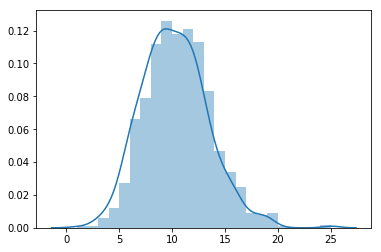

In [344]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['repeat'], ts_act_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [345]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [346]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [347]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: repeat - single (null)

Number of Positives lsa: 12 / 210
Number of Positives lss: 10 / 210
Number of overlapping positives: 1 / 210


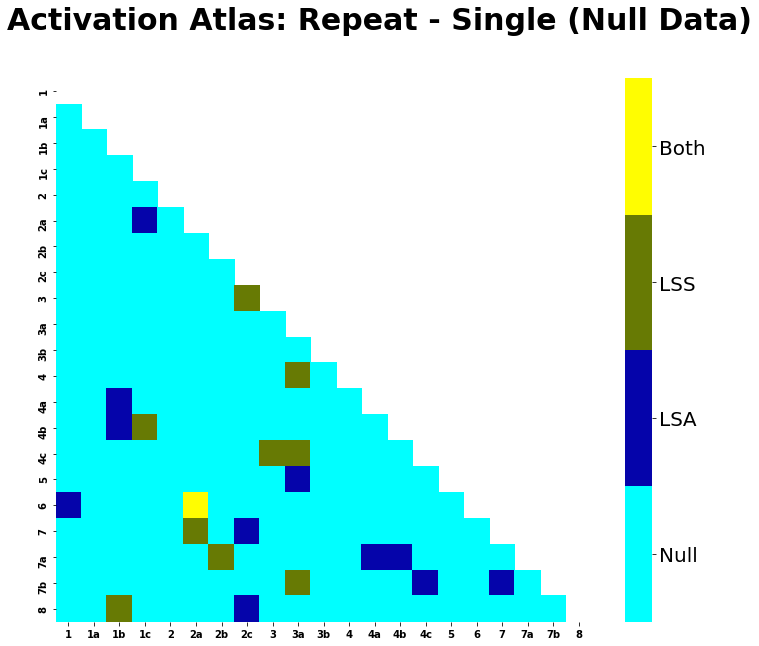

In [348]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['repeat'],
                       fb_act_lss_objs['single'],
                       fb_act_lsa_objs['repeat'],
                       fb_act_lsa_objs['single'],
                       'repeat', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

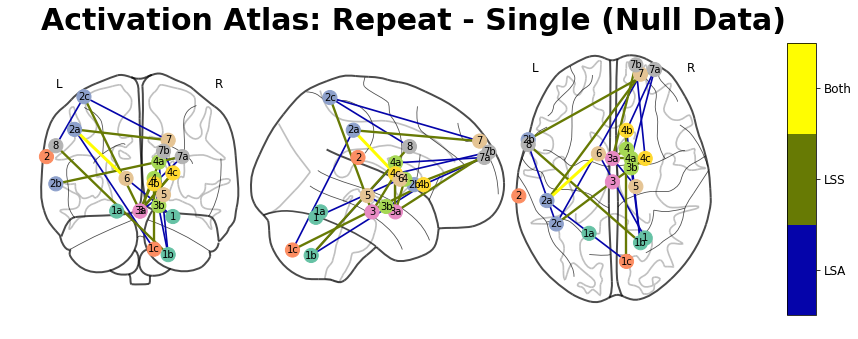

In [349]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.599

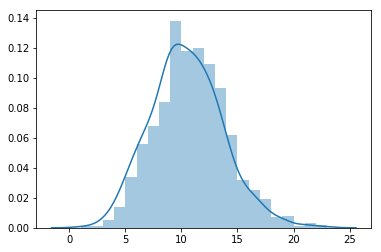

In [350]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['repeat'], fb_act_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [351]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.347

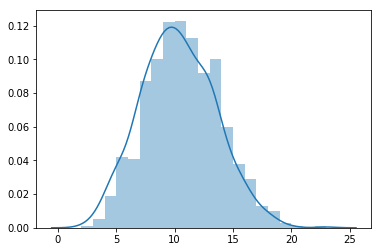

In [352]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['repeat'], fb_act_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [353]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [354]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [355]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: dual - repeat (task)

In [356]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['dual'],
                       ts_sch_lss_objs['repeat'],
                       ts_sch_lsa_objs['dual'],
                       ts_sch_lsa_objs['repeat'],
                       'dual', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: dual - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchxrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

Number of Positives lsa: 3759 / 79800
Number of Positives lss: 3902 / 79800
Number of overlapping positives: 219 / 79800


In [357]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

18

In [358]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

16

In [359]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

2

### Test significance of pairs of correlations

In [360]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [361]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: dual - repeat (null)

Number of Positives lsa: 3745 / 79800
Number of Positives lss: 3865 / 79800
Number of overlapping positives: 272 / 79800


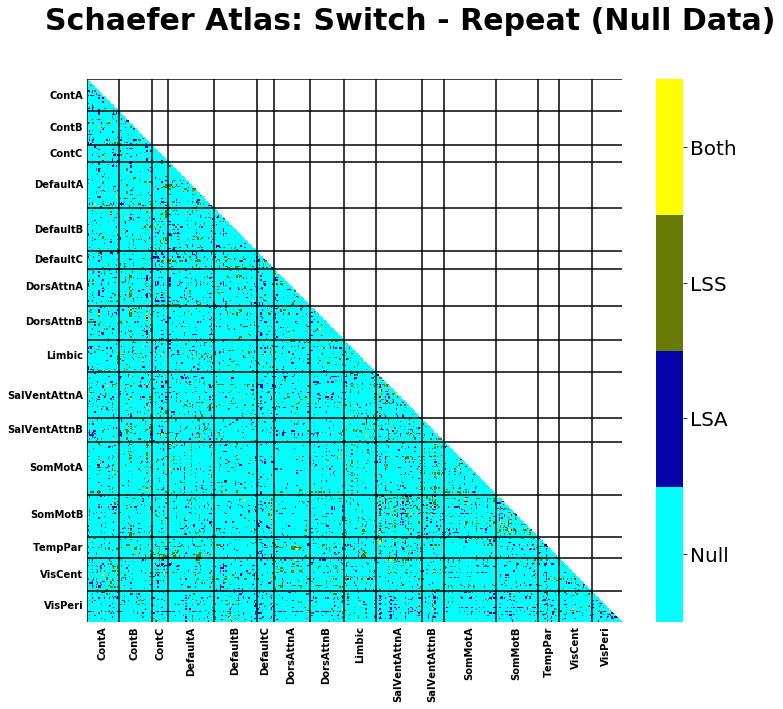

In [362]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['dual'],
                       fb_sch_lss_objs['repeat'],
                       fb_sch_lsa_objs['dual'],
                       fb_sch_lsa_objs['repeat'],
                       'dual', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: dual - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-switchxrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [363]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

40

In [364]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

2

In [365]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

0

### Test significance of pairs of correlations

In [366]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [367]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: dual - repeat (task)

In [368]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['dual'],
                       ts_act_lss_objs['repeat'],
                       ts_act_lsa_objs['dual'],
                       ts_act_lsa_objs['repeat'],
                       'dual', 'repeat',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: dual - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-switchxrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

Number of Positives lsa: 6 / 210
Number of Positives lss: 12 / 210
Number of overlapping positives: 0 / 210


In [369]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: dual - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-switchxrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [370]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['dual'], ts_act_lss_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

0.36

In [371]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.943

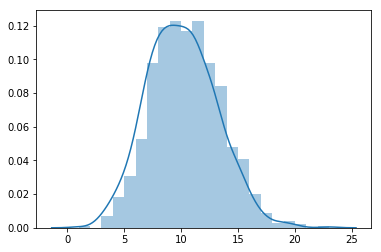

In [372]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['dual'], ts_act_lsa_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [373]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [374]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [375]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: dual - repeat (null)

Number of Positives lsa: 17 / 210
Number of Positives lss: 5 / 210
Number of overlapping positives: 0 / 210


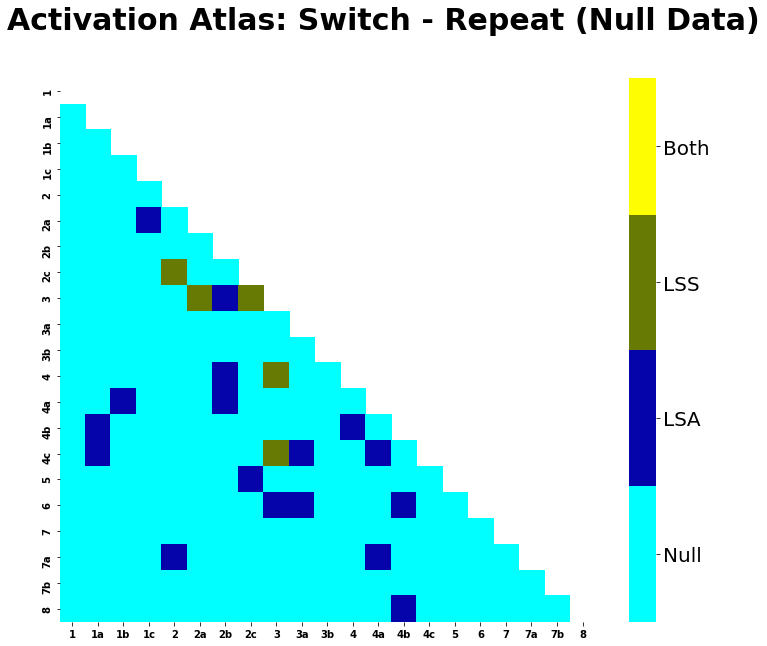

In [376]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['dual'],
                       fb_act_lss_objs['repeat'],
                       fb_act_lsa_objs['dual'],
                       fb_act_lsa_objs['repeat'],
                       'dual', 'repeat',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: dual - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-switchxrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

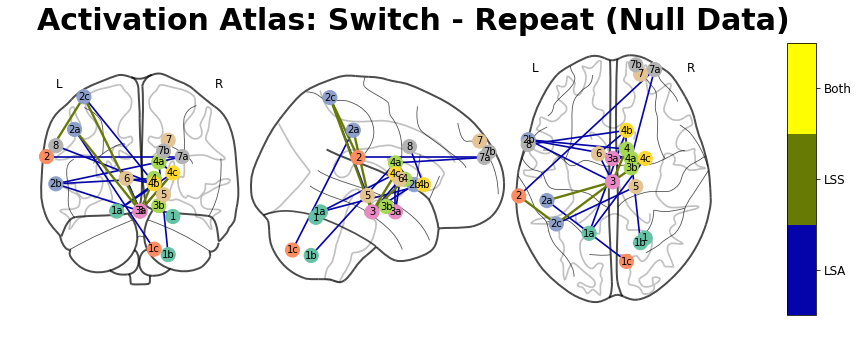

In [377]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: dual - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-switchxrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [378]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['dual'], fb_act_lss_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

0.982

In [379]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.025

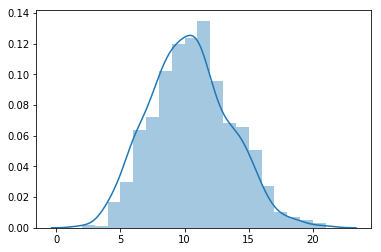

In [380]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['dual'], fb_act_lsa_objs['repeat'],
        'dual', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [381]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [382]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [383]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

## Participation Coefficient (Prespecified Community Assignment)

The participation coefficient measures how much a parcel connects to all other parcels, with 1 meaning the parcel is connected to all other parcels equally.

I expect the participation coefficient to be greater (i.e., closer to 1) in the task dual relative to rest, especially in frontal-parietal networks.

**Note**: participation coefficient is calculated separately for positively and negatively signed correlations.
My hypothesis is only for the positively signed correlations.

### Positive Participation Coefficient

### Discussion

There are significant differences between task and rest, but the most represented network is in the Default Mode network, with task showing a higher participation coefficient (as expected)

However, I should run the analysis again allowing the [communities to be decided by an algorithm rather than the schaefer network assignments](https://www.sciencedirect.com/science/article/pii/S0896627316305773?via%3Dihub)

### Negative Participation Coefficient

## Participation Coefficient (Louvain Community Assignment)

### Positive Participation Coefficient

### Negative Participation Coefficient

## Clustering Coefficient
Clustering Coefficient measures the number of local highly clustered nodes (nodes that form triangles of connections).

I expect task to have a higher(?) clustering coefficient relative to rest.
This is a rather expensive computation

## Modularity
Modularity is a measure of within community connections relative to outside community connections.
I expect task to have a lower modularity relative to rest.

## Investigate Beta Correlations between LSS and LSA

In [384]:
ts_act_lss_bs_objs = nf.get_layout_objects(lss_act_layout,
                                           ['dual', 'repeat', 'single'],
                                           suffix="betaseries", extension="nii.gz",
                                           task="taskswitch")
ts_act_lsa_bs_objs = nf.get_layout_objects(lsa_act_layout,
                                           ['dual', 'repeat', 'single'],
                                           suffix="betaseries", extension="nii.gz",
                                           task="taskswitch")

In [385]:
masker = NiftiLabelsMasker(ACT_ATLAS)

In [386]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False
    otherwise.
    modified from nipype:
    https://github.com/nipy/nipype/blob/b62d80/nipype/algorithms/confounds.py#L1129
    Parameters
    ----------
    points: nparray
        an numobservations by numdimensions numpy array of observations
    thresh: float
        the modified z-score to use as a threshold. Observations with
        a modified z-score (based on the median absolute deviation) greater
        than this value will be classified as outliers.
    Returns
    -------
        A bolean mask, of size numobservations-length array.
    .. note:: References
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
    """
    import numpy as np

    if len(points.shape) == 1:
        points = points[:, None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [387]:
collector = {}
for lss, lsa in zip(ts_act_lss_bs_objs['single'], ts_act_lsa_bs_objs['single']):
    lss_ts = masker.fit_transform(lss.path)
    lsa_ts = masker.fit_transform(lsa.path)
    outliers = is_outlier(lss_ts) | is_outlier(lsa_ts)
    lss_ts = lss_ts[~outliers]
    lsa_ts = lsa_ts[~outliers]
    correlations = []
    for col in range(lss_ts.shape[1]):
        correlations.append(np.corrcoef(lss_ts[:,col], lsa_ts[:,col])[1,0])
    collector[lss.entities['subject']] = correlations

In [388]:
columns = nf._read_adj_matrix(fb_act_lss_objs['dual'][0].path).columns
lss_lsa_beta_series_corr = pd.DataFrame.from_dict(collector, orient='index', columns=columns)
lss_lsa_beta_series_corr['average_correlation'] = lss_lsa_beta_series_corr.mean(axis=1)
lss_lsa_beta_series_corr.reset_index(inplace=True)
lss_lsa_beta_series_corr.head()

index         1        1a        1b        1c         2        2a  \
0  GE120001  0.789934  0.763413  0.646883  0.677216  0.818554  0.756598   
1  GE120002  0.823924  0.794200  0.665621  0.515565  0.809764  0.794751   
2  GE120003  0.694684  0.537461  0.506574  0.304841  0.027944  0.549778   
3  GE120004  0.436196  0.637011  0.432907  0.494426  0.678050  0.488877   
4  GE120005  0.798907  0.762906  0.671154  0.639900  0.737830  0.683296   

         2b        2c         3  ...        4a        4b        4c         5  \
0  0.743721  0.639174  0.661598  ...  0.780567  0.747064  0.741241  0.698273   
1  0.764402  0.772803  0.744650  ...  0.716147  0.663788  0.568367  0.787186   
2  0.693799  0.604677  0.210405  ...  0.254543  0.271008  0.594636  0.378806   
3  0.695504  0.684786  0.647351  ...  0.433214  0.581233  0.646363  0.458276   
4  0.814876  0.786678  0.711719  ...  0.809272  0.744847  0.766806  0.532826   

          6         7        7a        7b         8  average_correlation  
0  0.741148  0.621714  0.604088  0.553453  0.804729             0.708578  
1  0.706761  0.753423  0.646872  0.825757  0.644232             0.724843  
2  0.602237  0.502113  0.281233  0.418916  0.260940             0.450497  
3  0.390450  0.403032  0.464364  0.622633  0.534129             0.535723  
4  0.677002  0.869172  0.635709  0.755897  0.597941             0.727834  

[5 rows x 23 columns]

In [389]:
lss_lsa_beta_combine = pd.merge(
    lss_lsa_beta_series_corr,
    bold_qa_select.query("task == 'taskswitch'"),
    how='left',
    left_on='index',
    right_on='participant_id')

In [390]:
lss_lsa_beta_combine['hue'] = lss_lsa_beta_combine['index'].isin(good_participants)

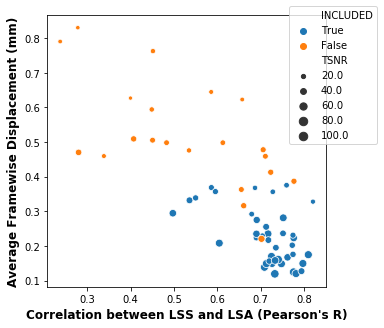

In [391]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='average_correlation', y='fd_mean', size='tsnr', hue='hue', hue_order=[True, False], data=lss_lsa_beta_combine, ax=ax)
ax.set_xlabel("Correlation between LSS and LSA (Pearson's R)", fontdict={'size': 'large', 'weight': 'heavy'});
ax.set_ylabel("Average Framewise Displacement (mm)", fontdict={'size': 'large', 'weight': 'heavy'});
ax.legend_.texts[0].set_text("INCLUDED");
ax.legend_.texts[3].set_text("TSNR");
ax.legend_.set(bbox_to_anchor=(1.2, 1.05))
save_eps(fig, "./outputs/lss_lsa_noise_relationship")

A high correlation between LSS and LSA means the methods agreed with each other.
The methods do not agree as much as motion increases and TSNR decreases.

### look at bs correlations in the null data

In [392]:
fb_act_lss_bs_objs = nf.get_layout_objects(lss_act_layout,
                                           ['dual', 'repeat', 'single'],
                                           suffix="betaseries", extension="nii.gz",
                                           task="fauxbold")
fb_act_lsa_bs_objs = nf.get_layout_objects(lsa_act_layout,
                                           ['dual', 'repeat', 'single'],
                                           suffix="betaseries", extension="nii.gz",
                                           task="fauxbold")

In [393]:
masker = NiftiLabelsMasker(ACT_ATLAS)

In [394]:
fb_collector = {}
for lss, lsa in zip(fb_act_lss_bs_objs['dual'], fb_act_lsa_bs_objs['dual']):
    lss_ts = masker.fit_transform(lss.path)
    lsa_ts = masker.fit_transform(lsa.path)
    outliers = is_outlier(lss_ts) | is_outlier(lsa_ts)
    lss_ts = lss_ts[~outliers]
    lsa_ts = lsa_ts[~outliers]
    correlations = []
    for col in range(lss_ts.shape[1]):
        correlations.append(np.corrcoef(lss_ts[:,col], lsa_ts[:,col])[1,0])
    fb_collector[lss.entities['subject']] = correlations

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [395]:
columns = nf._read_adj_matrix(fb_act_lss_objs['dual'][0].path).columns
lss_lsa_beta_series_corr = pd.DataFrame.from_dict(fb_collector, orient='index', columns=columns)
lss_lsa_beta_series_corr['average_correlation'] = lss_lsa_beta_series_corr.mean(axis=1)
lss_lsa_beta_series_corr.reset_index(inplace=True)
lss_lsa_beta_series_corr.head()

index         1        1a        1b        1c         2        2a  \
0  GE120001  0.634879  0.717606  0.831149  0.802560  0.703886  0.734197   
1  GE120002  0.703669  0.642921  0.718171  0.755757  0.874326  0.889942   
2  GE120003 -0.218453 -0.164035 -0.443194  0.553206 -0.058122 -0.035551   
3  GE120004  0.785199  0.514917  0.726602  0.563828  0.724607  0.642247   
4  GE120005  0.553660  0.626454  0.735533  0.049169  0.395719  0.541565   

         2b        2c         3  ...        4a        4b        4c         5  \
0  0.849878  0.777712  0.771413  ...  0.711460  0.739704  0.783433  0.775829   
1  0.598364  0.829804  0.795898  ...  0.870898  0.642906  0.764401  0.692823   
2  0.276220  0.586208  0.159267  ...  0.577329  0.442506  0.641324 -0.290756   
3  0.714180  0.529755  0.741497  ...  0.712751  0.457233  0.651099  0.714819   
4  0.516491  0.636529  0.629459  ...  0.512779  0.583051  0.601761  0.584347   

          6         7        7a        7b         8  average_correlation  
0  0.777735  0.833020  0.757909  0.694291  0.642849             0.757521  
1  0.743916  0.889884  0.818197  0.780236  0.624056             0.761932  
2  0.547570 -0.368813 -0.444728 -0.256759 -0.553969             0.064629  
3  0.707559  0.530524  0.578045  0.820535  0.598379             0.643233  
4  0.737947  0.438327  0.613999  0.554099  0.662694             0.555371  

[5 rows x 23 columns]

In [396]:
lss_lsa_beta_combine = pd.merge(
    lss_lsa_beta_series_corr,
    bold_qa_select.query("task == 'fauxbold'"),
    how='left',
    left_on='index',
    right_on='participant_id')

In [397]:
lss_lsa_beta_combine['hue'] = lss_lsa_beta_combine['index'].isin(good_participants)

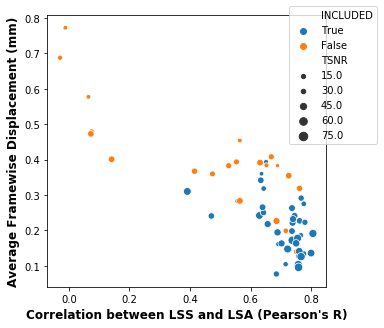

In [398]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='average_correlation', y='fd_mean', size='tsnr', hue='hue', hue_order=[True, False], data=lss_lsa_beta_combine, ax=ax)
ax.set_xlabel("Correlation between LSS and LSA (Pearson's R)", fontdict={'size': 'large', 'weight': 'heavy'});
ax.set_ylabel("Average Framewise Displacement (mm)", fontdict={'size': 'large', 'weight': 'heavy'});
ax.legend_.texts[0].set_text("INCLUDED");
ax.legend_.texts[3].set_text("TSNR");
ax.legend_.set(bbox_to_anchor=(1.2, 1.05))
save_eps(fig, "./outputs/lss_lsa_noise_relationship")

### Correlate average roi-roi condition specific correlations

Averaging over the 40/60 participants, is there good agreement between LSS's and LSA's pattern of responses?

Yes.

In [399]:
# correlate average matrices
lss_sch_dual_values = nf.bind_matrices(ts_sch_lss_objs['dual'], 'taskswitch').mean(axis=0).values
lsa_sch_dual_values = nf.bind_matrices(ts_sch_lsa_objs['dual'], 'taskswitch').mean(axis=0).values
np.corrcoef(lss_sch_dual_values, lsa_sch_dual_values)

array([[1.        , 0.90718694],
       [0.90718694, 1.        ]])

In [400]:
lss_sch_repeat_values = nf.bind_matrices(ts_sch_lss_objs['repeat'], 'taskswitch').mean(axis=0).values
lsa_sch_repeat_values = nf.bind_matrices(ts_sch_lsa_objs['repeat'], 'taskswitch').mean(axis=0).values
np.corrcoef(lss_sch_repeat_values, lsa_sch_repeat_values)

array([[1.        , 0.88222926],
       [0.88222926, 1.        ]])

In [401]:
lss_sch_single_values = nf.bind_matrices(ts_sch_lss_objs['single'], 'taskswitch').mean(axis=0).values
lsa_sch_single_values = nf.bind_matrices(ts_sch_lsa_objs['single'], 'taskswitch').mean(axis=0).values
np.corrcoef(lss_sch_single_values, lsa_sch_single_values)

array([[1.        , 0.94192065],
       [0.94192065, 1.        ]])

In [402]:
lss_act_single_values = nf.bind_matrices(ts_sch_lss_objs['single'], 'taskswitch').mean(axis=0).values
lsa_sch_single_values = nf.bind_matrices(ts_sch_lsa_objs['single'], 'taskswitch').mean(axis=0).values

## Validation Strategy